In [1]:
import os
os.environ["CUDA_LAUNCH_BLOCKING"] = "1"

# Text Classification

We did not do much classification in class although it is relevant in many industrial settings, for example:
- spam detection
- sentiment analysis
- hate speech detection

There are also several theoretical NLP problems that are framed as classification, such as Natural Language Inference.

Because it is very basic, it gives you freedom to use any NLP method:
- bag of words (not really seen in class)
- word embeddings
- LSTM/RNN
- fine-tuned Transformer Encoder (e.g. BERT)...
- ...with full fine-tuning or parameter efficient fine-tuning (e.g. LoRA)
- prompted LLM (e.g. Llama)...
- ...with standard prompting or chain of thought...
- ...with or without In-Context Learning examples

For this homework, we will study the detection of automatically generated text (more specifically, automatically generated research papers), based on the work of [Liyanage et al. 2022 "A Benchmark Corpus for the Detection of Automatically Generated Text in Academic Publications"](https://aclanthology.org/2022.lrec-1.501)

> Automatic text generation based on neural language models has achieved performance levels that make the generated text almost indistinguishable from those written by humans. Despite the value that text generation can have in various applications, it can also be employed for malicious tasks. The diffusion of such practices represent a threat to the quality of academic publishing. To address these problems, we propose in this paper two datasets comprised of artificially generated research content: a completely synthetic dataset and a partial text substitution dataset. In the first case, the content is completely generated by the GPT-2 model after a short prompt extracted from original papers. The partial or hybrid dataset is created by replacing several sentences of abstracts with sentences that are generated by the Arxiv-NLP model. We evaluate the quality of the datasets comparing the generated texts to aligned original texts using fluency metrics such as BLEU and ROUGE. The more natural the artificial texts seem, the more difficult they are to detect and the better is the benchmark. We also evaluate the difficulty of the task of distinguishing original from generated text by using state-of-the-art classification models.

# Installation and imports

Hit `Ctrl+S` to save a copy of the Colab notebook to your drive

Run on Google Colab GPU:
- Connect
- Modify execution
- GPU

![image.png](https://paullerner.github.io/aivancity_nlp/_static/colab_gpu.png)

In [2]:
!nvidia-smi

Thu Feb 27 19:59:54 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA L4                      Off |   00000000:00:03.0 Off |                    0 |
| N/A   42C    P8             12W /   72W |       0MiB /  23034MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----


T4 GPU (on Google Colab) offers 15GB of memory. This should be enough to run inference and fine-tune LLMs of a few billion parameters (or less, obviously)

Note, in `float32`, 1 parameter = 4 bytes so a LLM of 1B parameters holds 4GB of RAM.
But for full fine-tuning, you will need to store gradient activations (without gradient checkpointing) and optimizer states (with optimizers like Adam).

Turn to quantization for cheap inference of larger models or to Parameter Efficient Fine-Tuning for full-fine tuning of LLMs of a few billion parameters.

Much simpler solution: stick to smaller models of hundred of millions of parameters (e.g. BERT, GPT-2, T5).
You're not here to beat the state of the art but to learn NLP.

In [3]:
import torch
import os

In [4]:
assert torch.cuda.is_available(), "Connect to GPU and try again"

# Data
We will use the Hybrid subset of Vijini et al. in which some sentences of human-written abstracts where replaced by automatically-generated text. Experiments on the fully-generated subsets (or any other dataset) may provide bonus points (à faire)

There are no train-test split provided in the paper but we keep 80% to train and 20% to test, following Vijini et al.

In [5]:
import shutil

# Remplacez 'nom_du_dossier' par le chemin du dossier que vous souhaitez supprimer
dossier_a_supprimer = 'GeneratedTextDetection-main'

try:# Supprimer le dossier et tout son contenu
  shutil.rmtree(dossier_a_supprimer)
  print(f"Le dossier {dossier_a_supprimer} a été supprimé avec succès.")
except Exception:
  print(f"{dossier_a_supprimer} n\'existe peut être pas")
finally:
  print('téléchargemet du dataset')

GeneratedTextDetection-main n'existe peut être pas
téléchargemet du dataset


In [6]:
!wget https://github.com/vijini/GeneratedTextDetection/archive/refs/heads/main.zip
!unzip main

--2025-02-27 19:59:58--  https://github.com/vijini/GeneratedTextDetection/archive/refs/heads/main.zip
Resolving github.com (github.com)... 140.82.114.4
Connecting to github.com (github.com)|140.82.114.4|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://codeload.github.com/vijini/GeneratedTextDetection/zip/refs/heads/main [following]
--2025-02-27 19:59:59--  https://codeload.github.com/vijini/GeneratedTextDetection/zip/refs/heads/main
Resolving codeload.github.com (codeload.github.com)... 140.82.114.9
Connecting to codeload.github.com (codeload.github.com)|140.82.114.9|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified [application/zip]
Saving to: ‘main.zip’

main.zip                [  <=>               ] 800.25K  2.06MB/s    in 0.4s    

2025-02-27 20:00:00 (2.06 MB/s) - ‘main.zip’ saved [819461]

Archive:  main.zip
ab034465f857a93212a894fe598edb749345b6ff
   creating: GeneratedTextDetection-main/
  inflating: Gene

## homework data set

In [7]:
from pathlib import Path

In [8]:
root = Path("GeneratedTextDetection-main/Dataset/Hybrid_AbstractDataset")

In [9]:
train_texts, train_labels, test_texts, test_labels = [], [], [], []
for path in root.glob("*.txt"):
    with open(path, 'rt') as file:
        text = file.read()
        text = text.lstrip('\ufeff')
    label = int(path.name.endswith("generatedAbstract.txt"))
    doc_id = int(path.name.split("_")[0].split(".")[-1])
    if doc_id < 10522:
        test_texts.append(text)
        test_labels.append(label)
    else:
        train_texts.append(text)
        train_labels.append(label)

In [10]:
len(train_texts), len(train_labels), len(test_texts), len(test_labels)

(160, 160, 40, 40)

In [11]:
train_texts[0]

'The increasing amounts of semantic resources offer valuable storage of human knowledge; however, the probability of wrong entries increases with the increased size. The development of approaches that identify potentially spurious parts of a given knowledge base is thus becoming an increasingly impor- tant area of interest. In this work, we present a systematic evaluation of whether structure-only link analysis methods can already offer a scalable means to detecting possible anomalies, as well as poten- tially interesting novel relation candidates. Evaluating thirteen methods on eight different semantic resources, including Gene Ontology, Food Ontology, Marine Ontology and similar, we demonstrated that structure-only link analysis could offer scalable anomaly detection for a subset of the data sets. Further, we demonstrated that by considering symbolic node embedding, explanations of the predic- tions (links) could be obtained, making this branch of methods potentially more valuable th

In [12]:
train_labels[0]

0

In [13]:
train_texts[10]

'Collaborative filtering (CF) is an important approach for recommendation system which is widely used in a great number of aspects of our life, heavily in the online-based commercial systems. One popular algorithms in CF is the K-nearest neighbors (KNN) algorithm, in which the similarity measures are used to determine nearest neighbors of a user, and thus to quantify the dependency degree between the relative user/item pair. Consequently, CF approach is not just sensitive to the similarity measure, yet it is completely contingent on selection of that measure. While Jaccard - as one of those commonly used similarity measures for CF tasks - concerns the existence of ratings, other numerical measures such as cosine and Pearson concern the magnitude of ratings. Particularly speaking, Jaccard is not a dominant measure, but it is long proven to be an important factor to improve any measure. Therefore, in our continuous efforts to find the most effective similarity measures for CF, this resea

In [14]:
train_labels[10]

0

# Good luck!

It's now up to you to solve the problem. You are free to choose any NLP method (cf. the list I gave above)
but you should motivate your choice.
You can also compare several methods to get bonus points. (compare 3 méthode)

# Submission instructions


**Deadline: Thursday 27th of February 23:59 (Paris CEST)** (strict deadline, 5 points malus per day late, so 4 days late means 0/20)

This is a **group work** of **3 members**.

You will have to submit your **code** and a **report** which will be graded (instructions below) by email to lerner@isir.upmc.fr.

The homework (continuous assessment) will account for 50% of your final grade.

## Report

The report should be **a single .pdf file of max. 4 pages** (concision is key).
Please name the pdf with the name of your group as written in the spreadsheet https://docs.google.com/spreadsheets/d/1UbApMhPC_wof-GoByjkV7kgD5YMbjcFFPqPUCB0YRtQ/edit?usp=sharing for example `ABC.pdf`.

It should follow the following structure:

### Introduction
A few sentences placing the work in context. Limit it to a few paragraphs at most; since your report is based on Vijini et al., you don’t have to motivate that work. However, it should be clear enough what Vijini et al. is
about and what its contributions are.

### Methodology

Describe the methods you are using to tackle the problem and motivate it: why this method and not another?  
What are its advantages and inconvenients?  
What experiment are you running to measure the efficiency or effectiveness of your method to tackle the problem?

#### Model Descriptions
Describe the models you used, including the architecture, learning objective and the number of parameters.

#### Datasets
Describe the datasets you used and how you obtained them.

#### Hyperparameters
Describe how you set the hyperparameters and what was the source for their value (e.g., paper, code, or your guess).

#### Implementation
Describe whether you use existing code or write your own code.

#### Experimental Setup
Explain how you ran your experiments, e.g. the CPU/GPU resources.

### Results
Start with a high-level overview of your results. Keep this
section as factual and precise as possible.
Logically
group related results into sections.

Remember to add plots and diagrams to illustrate your methods or results if necessary.



### Discussion

Describe which parts of your project were difficult or took much more time than you expected.


### Contributions

You should state the contributions of each member of the group.



## Code

You can submit your code either as:

- single .zip file with your entire source code (e.g. several .py files)
- link to a GitHub/GitLab repository (in this case, **include the link in your .pdf report**)
- link to a Google Colab Notebook (your code may be quite simple so it may fit in a single notebook;
  likewise, in this case, **include the link in your .pdf report**)

# Let's start

# Installation and Import

In [15]:
!pip install lazypredict
!pip install tensorflow

In [16]:
#general
from lazypredict.Supervised import LazyClassifier
from collections import Counter
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
import spacy

#Sklearn
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, precision_score, recall_score, f1_score, roc_auc_score
from sklearn.metrics import roc_curve, auc ,precision_recall_fscore_support, accuracy_score
from sklearn.manifold import TSNE
from sklearn.decomposition import NMF

#process
import psutil
import time
import subprocess


#tensorflow
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, SimpleRNN, LSTM, Dense, Dropout,Bidirectional
from sklearn.metrics import classification_report, confusion_matrix, precision_score, recall_score, f1_score, roc_auc_score
from tensorflow.keras.callbacks import Callback


#torch & transformer
import torch
from torch.utils.data import Dataset
from transformers import AutoTokenizer, AutoModelForSequenceClassification, Trainer, TrainingArguments

In [17]:
import nltk

#nltk local download
nltk_data_path = '/content/nltk_data'
os.makedirs(nltk_data_path, exist_ok=True)
nltk.data.path.append(nltk_data_path)
nltk.download('punkt_tab', download_dir=nltk_data_path)
nltk.download('stopwords', download_dir=nltk_data_path)
print("Chemins de recherche de NLTK :", nltk.data.path)

import string
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

[nltk_data] Downloading package punkt_tab to /content/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.
[nltk_data] Downloading package stopwords to /content/nltk_data...


Chemins de recherche de NLTK : ['/root/nltk_data', '/usr/nltk_data', '/usr/share/nltk_data', '/usr/lib/nltk_data', '/usr/share/nltk_data', '/usr/local/share/nltk_data', '/usr/lib/nltk_data', '/usr/local/lib/nltk_data', '/content/nltk_data']


[nltk_data]   Unzipping corpora/stopwords.zip.


# Data analysis

In [18]:
df = pd.DataFrame({
    "text": train_texts,
    "label": train_labels
})

## General

### Distribution: balanced data?

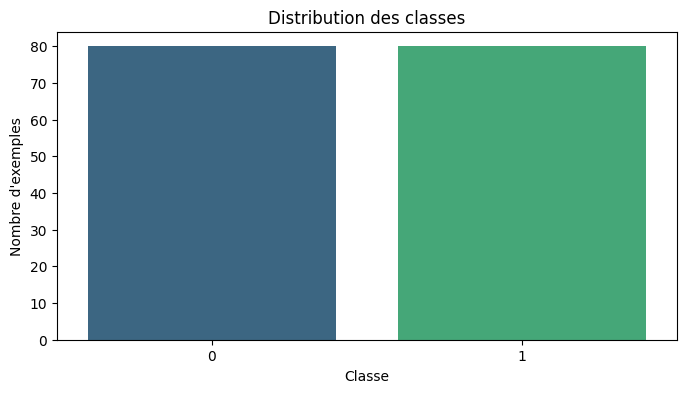

In [19]:
plt.figure(figsize=(8, 4))
sns.countplot(x="label", data=df, palette="viridis")
plt.title("Distribution des classes")
plt.xlabel("Classe")
plt.ylabel("Nombre d'exemples")
plt.show()

###text length

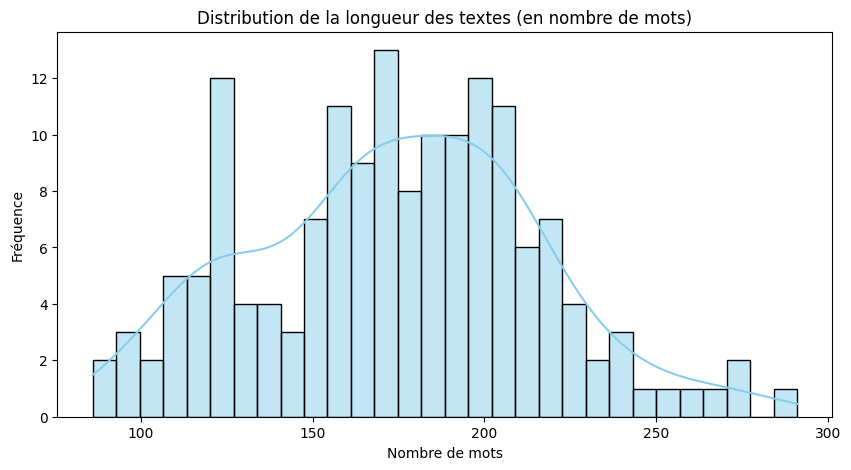

In [20]:
df["text_length"] = df["text"].apply(lambda x: len(x.split()))

plt.figure(figsize=(10, 5))
sns.histplot(df["text_length"], bins=30, kde=True, color="skyblue")
plt.title("Distribution de la longueur des textes (en nombre de mots)")
plt.xlabel("Nombre de mots")
plt.ylabel("Fréquence")
plt.show()

### Frequency

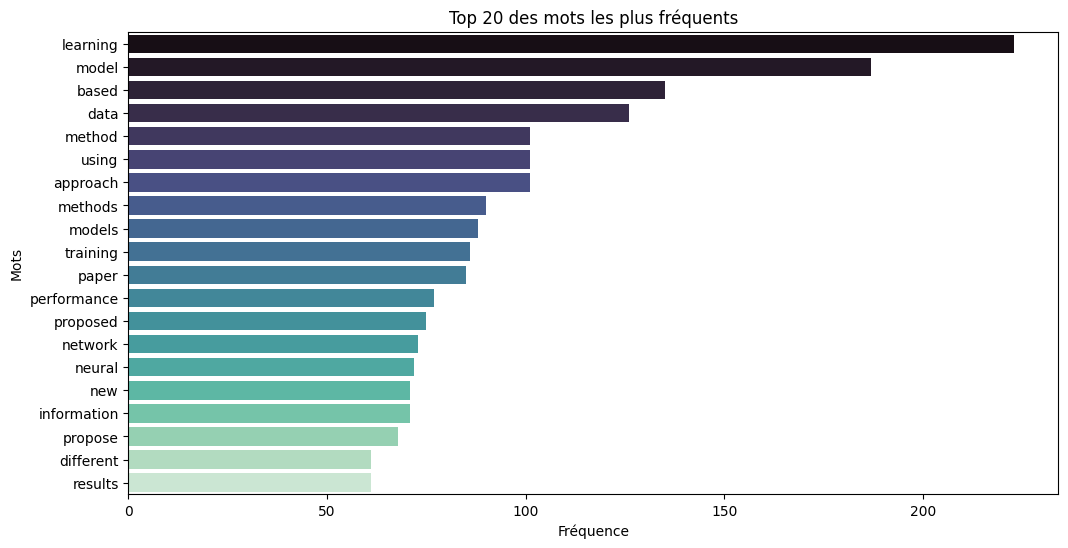

In [21]:
vectorizer = CountVectorizer(stop_words="english")
X_counts = vectorizer.fit_transform(df["text"])
word_counts = X_counts.sum(axis=0).A1  # Convertir en tableau 1D
words = vectorizer.get_feature_names_out()

# Créer un DataFrame des mots et de leurs fréquences
df_counts = pd.DataFrame({"word": words, "count": word_counts})
df_counts = df_counts.sort_values(by="count", ascending=False)

# Afficher les 20 mots les plus fréquents
plt.figure(figsize=(12, 6))
sns.barplot(x="count", y="word", data=df_counts.head(20), palette="mako")
plt.title("Top 20 des mots les plus fréquents")
plt.xlabel("Fréquence")
plt.ylabel("Mots")
plt.show()

### Word cloud (just for flex not really useful)

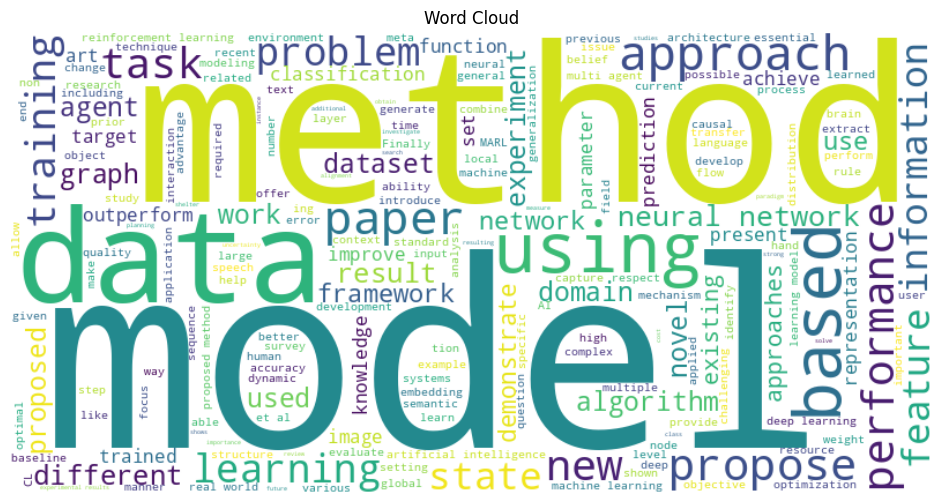

In [22]:
# Générer une word cloud à partir de tous les textes
all_text = " ".join(df["text"])
wordcloud = WordCloud(stopwords=set(vectorizer.get_stop_words()),
                      background_color="white",
                      width=800, height=400).generate(all_text)

plt.figure(figsize=(12, 6))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.title("Word Cloud")
plt.show()

## Complexe analysis

### lexique diversity

In [23]:
def compute_ttr(text):
    tokens = nltk.word_tokenize(text)
    return len(set(tokens)) / len(tokens) if tokens else 0

def plot_ttr_distribution(df, label_filter=None):
    if label_filter is not None:
        df_filtered = df[df["label"] == label_filter]
        title_suffix = f" (Label {label_filter})"
    else:
        df_filtered = df
        title_suffix = " (Tous les labels)"

    # On suppose que la colonne "TTR" n'existe pas encore
    df_filtered = df_filtered.copy()
    df_filtered["TTR"] = df_filtered["text"].apply(compute_ttr)

    plt.figure(figsize=(8, 5))
    sns.histplot(df_filtered["TTR"], bins=10, kde=True, color="skyblue")
    plt.title("Distribution du Ratio Type-Token (Diversité lexicale)" + title_suffix)
    plt.xlabel("Ratio Type-Token")
    plt.ylabel("Fréquence")
    plt.show()

### embeding

In [24]:
def plot_tsne(df, label_filter=None):
    if label_filter is not None:
        df_filtered = df[df["label"] == label_filter]
        title_suffix = f" (Label {label_filter})"
    else:
        df_filtered = df
        title_suffix = " (Tous les labels)"

    vectorizer_tfidf = TfidfVectorizer(stop_words="english")
    X_tfidf = vectorizer_tfidf.fit_transform(df_filtered["text"])
    tsne = TSNE(n_components=2, random_state=42)
    X_tsne = tsne.fit_transform(X_tfidf.toarray())

    plt.figure(figsize=(8, 6))
    # Pour les scatterplots, on peut colorer par label seulement si plusieurs labels existent
    if "label" in df_filtered.columns and df_filtered["label"].nunique() > 1:
        sns.scatterplot(x=X_tsne[:, 0], y=X_tsne[:, 1], hue=df_filtered["label"], palette="viridis", s=100)
    else:
        plt.scatter(X_tsne[:, 0], X_tsne[:, 1], s=100, color="blue")
    plt.title("Visualisation des embeddings (t-SNE)" + title_suffix)
    plt.xlabel("Composante 1")
    plt.ylabel("Composante 2")
    plt.legend(title="Label")
    plt.show()

### topic visualisation

In [25]:
from sklearn.decomposition import NMF

def plot_topic_modeling(df, n_topics=2, label_filter=None):
    if label_filter is not None:
        df_filtered = df[df["label"] == label_filter]
        title_suffix = f" (Label {label_filter})"
    else:
        df_filtered = df
        title_suffix = " (Tous les labels)"

    vectorizer_tfidf = TfidfVectorizer(stop_words="english")
    X_tfidf = vectorizer_tfidf.fit_transform(df_filtered["text"])
    nmf_model = NMF(n_components=n_topics, random_state=42)
    W = nmf_model.fit_transform(X_tfidf)
    H = nmf_model.components_
    feature_names = vectorizer_tfidf.get_feature_names_out()

    def display_topics(H, feature_names, num_top_words=10):
        topics = {}
        for topic_idx, topic in enumerate(H):
            top_indices = topic.argsort()[:-num_top_words - 1:-1]
            top_words = [feature_names[i] for i in top_indices]
            topics[f"Topic {topic_idx+1}"] = top_words
        return topics

    topics = display_topics(H, feature_names)
    print("Topics extraits par NMF" + title_suffix + ":")
    for topic, words in topics.items():
        print(f"{topic}: {', '.join(words)}")

    # Afficher les top mots pour chaque topic
    for topic_idx, topic in enumerate(H):
        top_indices = topic.argsort()[:-11:-1]
        top_words = [feature_names[i] for i in top_indices]
        top_values = topic[top_indices]
        plt.figure(figsize=(10, 5))
        sns.barplot(x=top_values, y=top_words, palette="mako")
        plt.title(f"Top mots pour Topic {topic_idx+1}" + title_suffix)
        plt.xlabel("Importance")
        plt.ylabel("Mots")
        plt.show()

### VIsualisation:

=== Analyse sur tous les labels ===


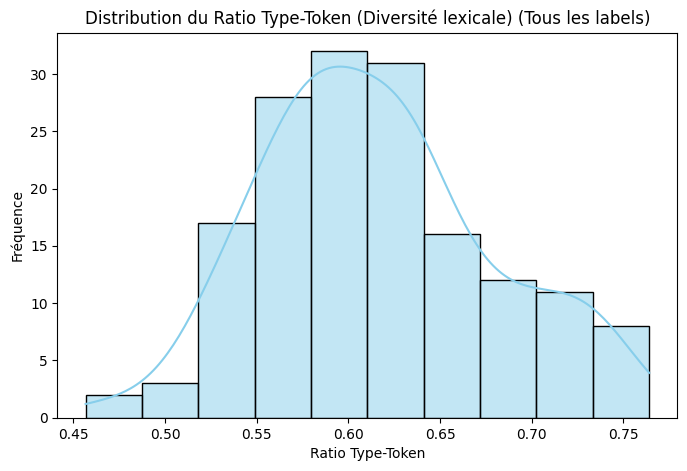

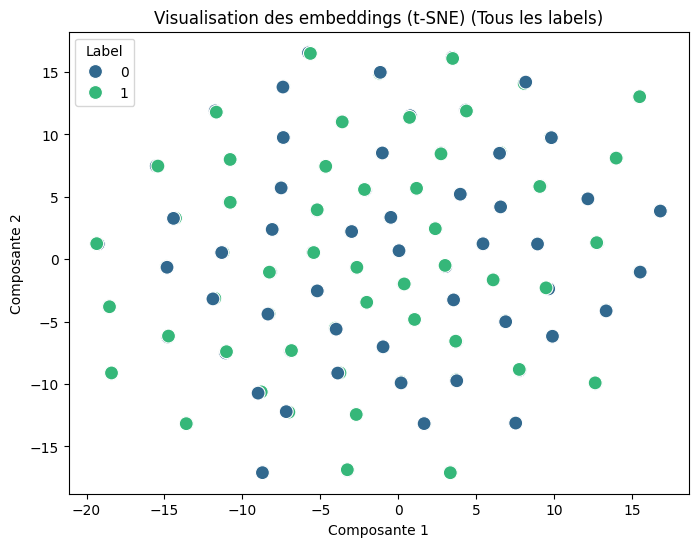

Topics extraits par NMF (Tous les labels):
Topic 1: model, learning, data, method, training, models, proposed, information, based, using
Topic 2: inference, tree, active, search, time, al, et, algorithms, sparse, pruning


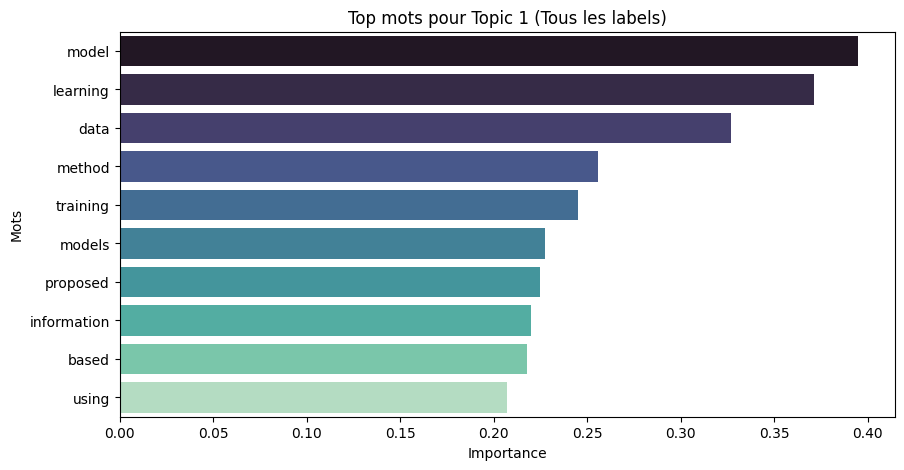

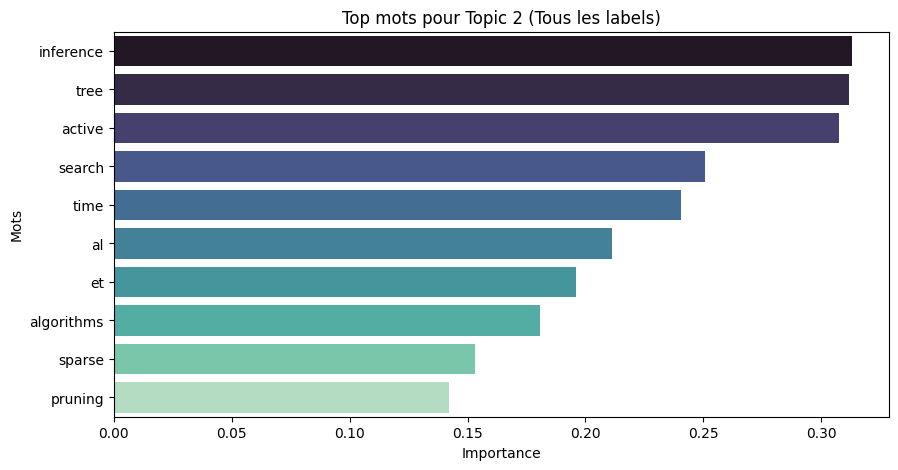

=== Analyse pour le label 0 ===


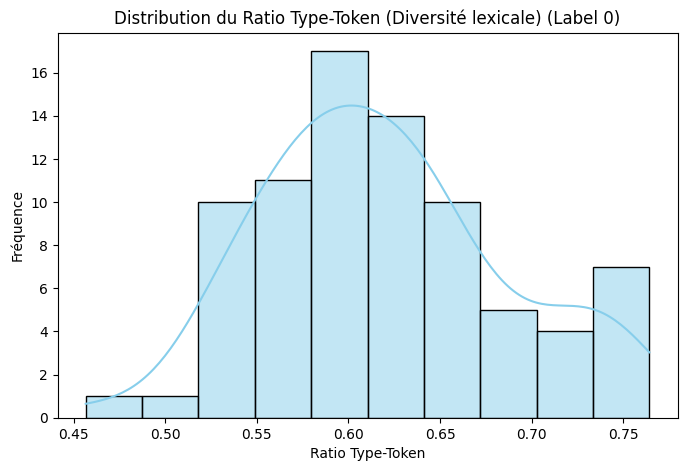

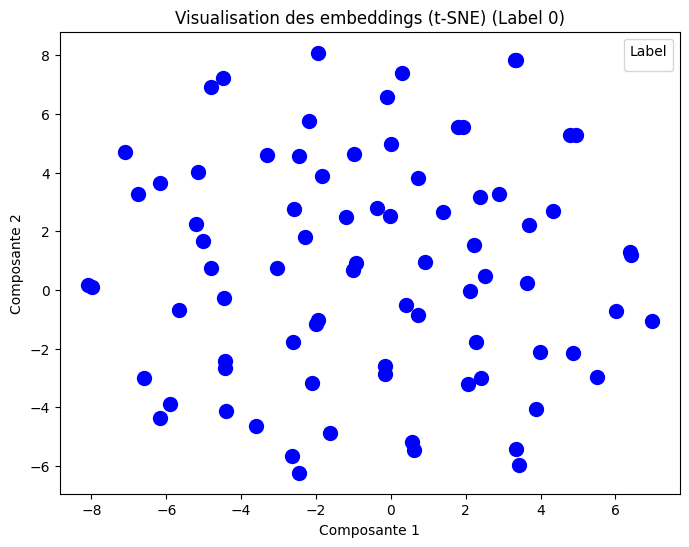

Topics extraits par NMF (Label 0):
Topic 1: learning, model, data, method, training, based, methods, proposed, models, using
Topic 2: active, inference, search, tree, time, al, et, ai, planning, btai


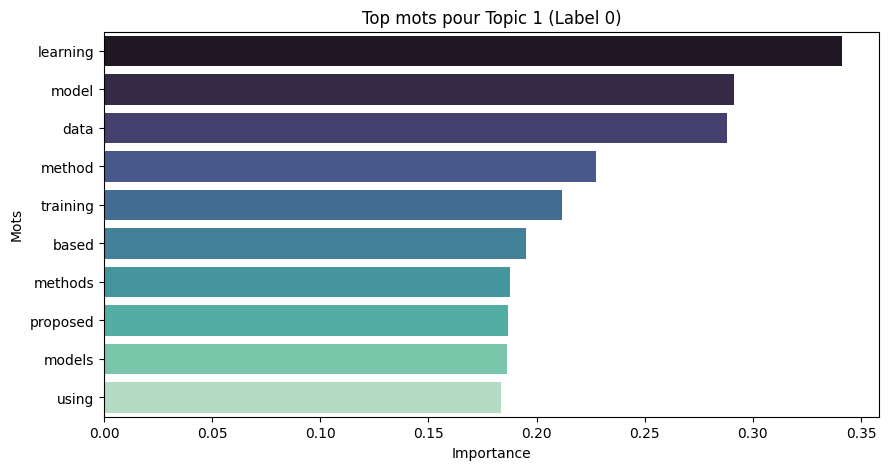

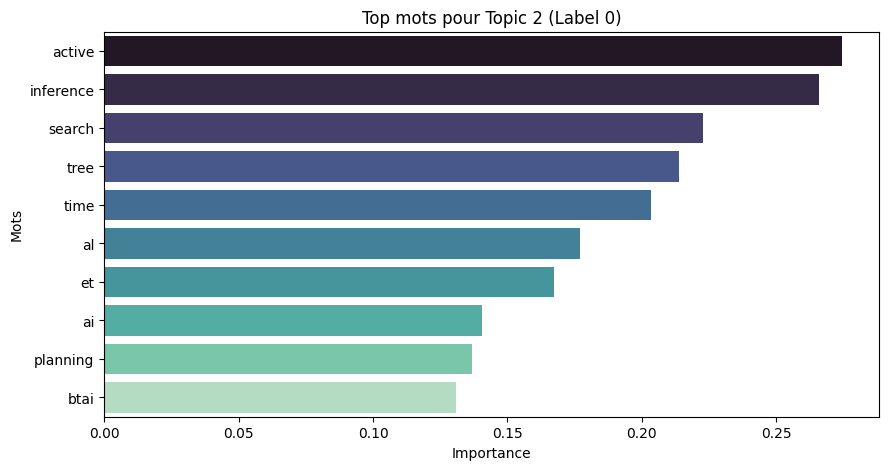

=== Analyse pour le label 1 ===


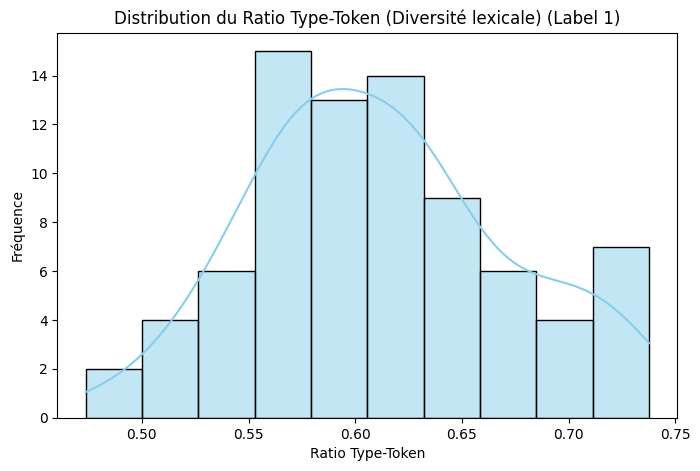

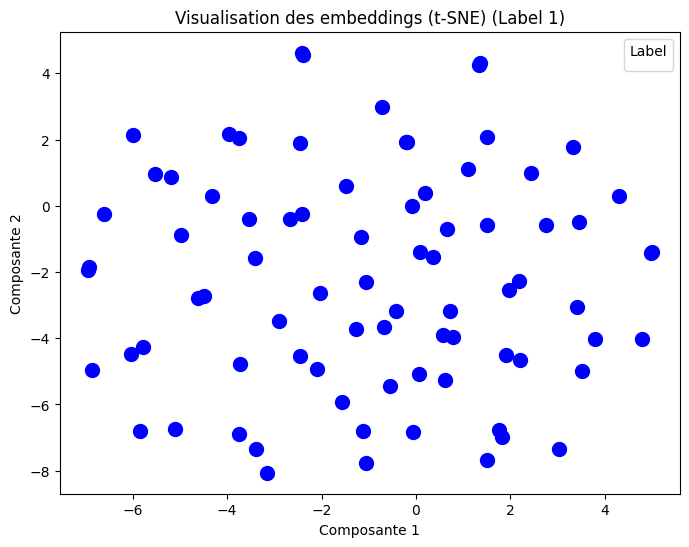

Topics extraits par NMF (Label 1):
Topic 1: model, learning, data, method, training, models, information, proposed, based, using
Topic 2: tree, inference, active, time, search, al, algorithms, et, current, sparse


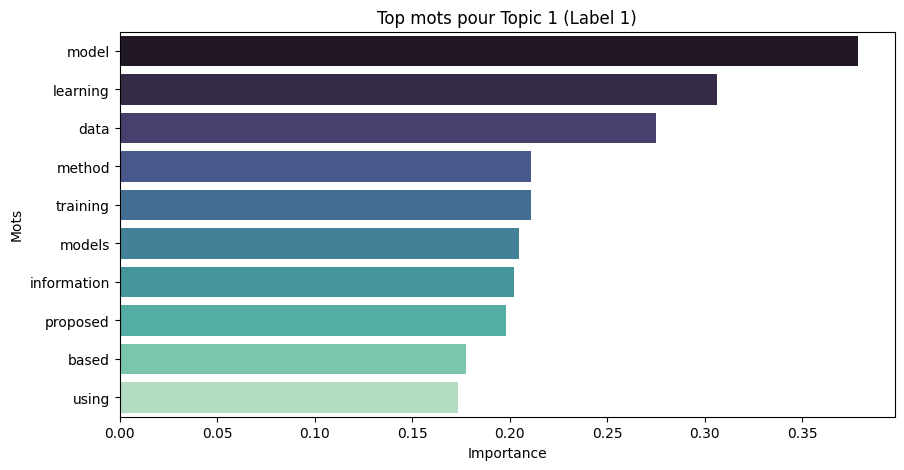

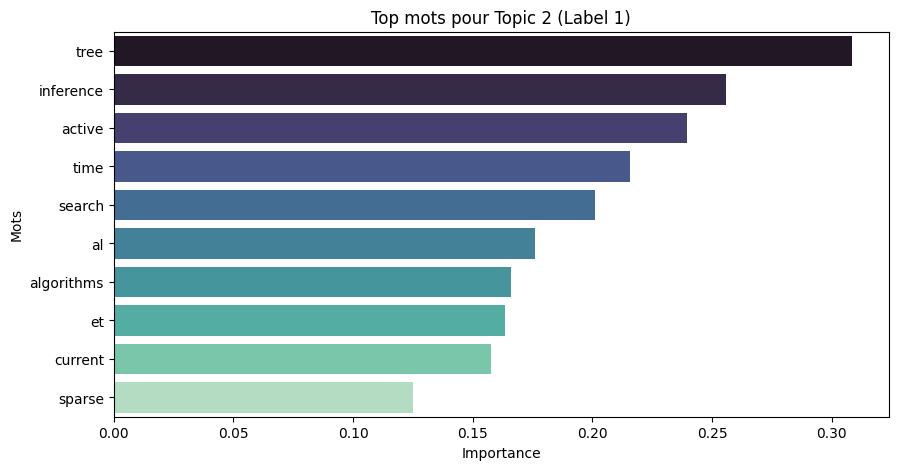

In [26]:
for filter_val in [None, 0, 1]:
    if filter_val is None:
        print("=== Analyse sur tous les labels ===")
    else:
        print(f"=== Analyse pour le label {filter_val} ===")

    plot_ttr_distribution(df, label_filter=filter_val)

    plot_tsne(df, label_filter=filter_val)

    plot_topic_modeling(df, n_topics=2, label_filter=filter_val)



# Data Preprocessing

In [27]:
stop_words = set(stopwords.words('english'))

def preprocess_text(text):
    # Mettre en minuscules
    text = text.lower()

    # Supprimer la ponctuation
    text = text.translate(str.maketrans('', '', string.punctuation))

    # Tokeniser le texte
    tokens = word_tokenize(text)

    # Supprimer les stopwords
    tokens = [token for token in tokens if token not in stop_words]

    return tokens

In [28]:
tokenized_train_texts = [preprocess_text(text) for text in train_texts]
print("Tokens prétraités :", tokenized_train_texts[0][:10])

Tokens prétraités : ['increasing', 'amounts', 'semantic', 'resources', 'offer', 'valuable', 'storage', 'human', 'knowledge', 'however']


# Features extraction

###  bag of word

In [29]:
# Instanciation du vectorizer
vectorizer_bow = CountVectorizer()

# Transformation des textes d'entraînement et de test en matrices de comptage
X_train_bow = vectorizer_bow.fit_transform(train_texts)
X_test_bow = vectorizer_bow.transform(test_texts)

print("Taille de la matrice d'entraînement (bag-of-words) :", X_train_bow.shape)


Taille de la matrice d'entraînement (bag-of-words) : (160, 3180)


### Tf-idf

In [30]:
# Instanciation du vectorizer TF-IDF
vectorizer_tfidf = TfidfVectorizer()

# Transformation des textes d'entraînement et de test en matrices TF-IDF
X_train_tfidf = vectorizer_tfidf.fit_transform(train_texts)
X_test_tfidf = vectorizer_tfidf.transform(test_texts)

print("Taille de la matrice d'entraînement (TF-IDF) :", X_train_tfidf.shape)


Taille de la matrice d'entraînement (TF-IDF) : (160, 3180)


# Lazy predict to compare model

In [31]:

def training(X_train,X_test, Y_train, Y_test):
    print("Utilisation du CPU avant entraînement:", psutil.cpu_percent(interval=1), "%")
    print("Mémoire virtuelle avant entraînement:", psutil.virtual_memory())

    #training
    clf = LazyClassifier(verbose=0, ignore_warnings=True, custom_metric=None)
    models, predictions = clf.fit(X_train.toarray(), X_test.toarray(), Y_train, Y_test)


    # Afficher l'utilisation finale du CPU et de la mémoire
    print("Utilisation du CPU après entraînement:", psutil.cpu_percent(interval=1), "%")
    print("Mémoire virtuelle après entraînement:", psutil.virtual_memory())


    return models, predictions

## TFidf

In [32]:
tfidf_models,tfidf_predictions=training(X_train_tfidf, X_test_tfidf, train_labels, test_labels)

Utilisation du CPU avant entraînement: 30.5 %
Mémoire virtuelle avant entraînement: svmem(total=56866914304, available=53841240064, percent=5.3, used=2366902272, free=47384285184, active=854241280, inactive=7943077888, buffers=436686848, cached=6679040000, shared=1847296, slab=324419584)


100%|██████████| 32/32 [00:09<00:00,  3.40it/s]


[LightGBM] [Info] Number of positive: 80, number of negative: 80
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000724 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2553
[LightGBM] [Info] Number of data points in the train set: 160, number of used features: 138
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with

In [33]:
tfidf_models

Accuracy  Balanced Accuracy  ROC AUC  F1 Score  \
Model                                                                           
XGBClassifier                      0.68               0.68     0.68      0.67   
LGBMClassifier                     0.62               0.62     0.62      0.62   
BernoulliNB                        0.62               0.62     0.62      0.62   
NearestCentroid                    0.57               0.57     0.57      0.57   
LinearDiscriminantAnalysis         0.55               0.55     0.55      0.55   
RandomForestClassifier             0.55               0.55     0.55      0.55   
SVC                                0.55               0.55     0.55      0.55   
LinearSVC                          0.53               0.53     0.53      0.52   
LogisticRegression                 0.53               0.53     0.53      0.52   
AdaBoostClassifier                 0.53               0.53     0.53      0.52   
ExtraTreesClassifier               0.53               0.53     0.53      0.50   
RidgeClassifier                    0.53               0.53     0.53      0.52   
Perceptron                         0.53               0.53     0.53      0.52   
NuSVC                              0.53               0.53     0.53      0.49   
PassiveAggressiveClassifier        0.53               0.53     0.53      0.52   
SGDClassifier                      0.53               0.53     0.53      0.52   
RidgeClassifierCV                  0.53               0.53     0.53      0.52   
DecisionTreeClassifier             0.50               0.50     0.50      0.50   
BaggingClassifier                  0.50               0.50     0.50      0.47   
DummyClassifier                    0.50               0.50     0.50      0.33   
GaussianNB                         0.50               0.50     0.50      0.49   
LabelPropagation                   0.50               0.50     0.50      0.33   
KNeighborsClassifier               0.50               0.50     0.50      0.37   
LabelSpreading                     0.50               0.50     0.50      0.33   
QuadraticDiscriminantAnalysis      0.50               0.50     0.50      0.50   
ExtraTreeClassifier                0.47               0.48     0.48      0.47   
CalibratedClassifierCV             0.47               0.47     0.47      0.47   

                               Time Taken  
Model                                      
XGBClassifier                        0.49  
LGBMClassifier                       0.16  
BernoulliNB                          0.10  
NearestCentroid                      0.13  
LinearDiscriminantAnalysis           0.96  
RandomForestClassifier               0.30  
SVC                                  0.15  
LinearSVC                            0.97  
LogisticRegression                   0.14  
AdaBoostClassifier                   0.49  
ExtraTreesClassifier                 0.34  
RidgeClassifier                      0.10  
Perceptron                           0.12  
NuSVC                                0.12  
PassiveAggressiveClassifier          0.13  
SGDClassifier                        0.13  
RidgeClassifierCV                    0.18  
DecisionTreeClassifier               0.12  
BaggingClassifier                    0.29  
DummyClassifier                      0.07  
GaussianNB                           0.08  
LabelPropagation                     0.08  
KNeighborsClassifier                 0.07  
LabelSpreading                       0.12  
QuadraticDiscriminantAnalysis        0.16  
ExtraTreeClassifier                  0.07  
CalibratedClassifierCV               3.21

## Bag of words

In [34]:
bow_models,bow_predictions=training(X_train_bow, X_test_bow, train_labels, test_labels)


Utilisation du CPU avant entraînement: 23.0 %
Mémoire virtuelle avant entraînement: svmem(total=56866914304, available=53407182848, percent=6.1, used=2792280064, free=46908608512, active=874131456, inactive=8314941440, buffers=453005312, cached=6713020416, shared=10240000, slab=329248768)


100%|██████████| 32/32 [00:07<00:00,  4.00it/s]


[LightGBM] [Info] Number of positive: 80, number of negative: 80
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000690 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 735
[LightGBM] [Info] Number of data points in the train set: 160, number of used features: 138
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive ga

In [35]:
bow_models

Accuracy  Balanced Accuracy  ROC AUC  F1 Score  \
Model                                                                           
ExtraTreesClassifier               0.65               0.65     0.65      0.64   
BernoulliNB                        0.62               0.62     0.62      0.62   
RandomForestClassifier             0.60               0.60     0.60      0.58   
LGBMClassifier                     0.60               0.60     0.60      0.60   
XGBClassifier                      0.60               0.60     0.60      0.60   
ExtraTreeClassifier                0.60               0.60     0.60      0.60   
LinearSVC                          0.57               0.57     0.57      0.57   
RidgeClassifierCV                  0.57               0.57     0.57      0.57   
RidgeClassifier                    0.57               0.57     0.57      0.57   
DecisionTreeClassifier             0.55               0.55     0.55      0.55   
PassiveAggressiveClassifier        0.55               0.55     0.55      0.55   
NearestCentroid                    0.55               0.55     0.55      0.55   
Perceptron                         0.55               0.55     0.55      0.54   
LogisticRegression                 0.55               0.55     0.55      0.55   
LinearDiscriminantAnalysis         0.53               0.53     0.53      0.52   
SVC                                0.53               0.53     0.53      0.50   
SGDClassifier                      0.53               0.53     0.52      0.52   
GaussianNB                         0.53               0.53     0.53      0.52   
QuadraticDiscriminantAnalysis      0.53               0.53     0.52      0.42   
AdaBoostClassifier                 0.50               0.50     0.50      0.49   
KNeighborsClassifier               0.50               0.50     0.50      0.33   
DummyClassifier                    0.50               0.50     0.50      0.33   
LabelPropagation                   0.50               0.50     0.50      0.33   
NuSVC                              0.50               0.50     0.50      0.50   
LabelSpreading                     0.50               0.50     0.50      0.33   
BaggingClassifier                  0.47               0.47     0.47      0.47   
CalibratedClassifierCV             0.45               0.45     0.45      0.44   

                               Time Taken  
Model                                      
ExtraTreesClassifier                 0.31  
BernoulliNB                          0.09  
RandomForestClassifier               0.31  
LGBMClassifier                       0.11  
XGBClassifier                        0.22  
ExtraTreeClassifier                  0.07  
LinearSVC                            0.90  
RidgeClassifierCV                    0.14  
RidgeClassifier                      0.13  
DecisionTreeClassifier               0.10  
PassiveAggressiveClassifier          0.13  
NearestCentroid                      0.12  
Perceptron                           0.13  
LogisticRegression                   0.13  
LinearDiscriminantAnalysis           0.41  
SVC                                  0.12  
SGDClassifier                        0.12  
GaussianNB                           0.07  
QuadraticDiscriminantAnalysis        0.22  
AdaBoostClassifier                   0.36  
KNeighborsClassifier                 0.07  
DummyClassifier                      0.06  
LabelPropagation                     0.07  
NuSVC                                0.12  
LabelSpreading                       0.12  
BaggingClassifier                    0.24  
CalibratedClassifierCV               3.00

## Hyperparameters


In [36]:
import numpy as np
from sklearn.naive_bayes import BernoulliNB
from xgboost import XGBClassifier
from sklearn.tree import ExtraTreeClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score

### BernouilliNB

#### TFIDF

In [37]:
# ----- Hyperparamètres et recherche pour BernoulliNB -----
param_grid_BNB = {
    'alpha': [0.1, 0.5, 1.0, 2.0],
    'binarize': [0.0, 0.5, 1.0]
}

X_train,X_test,y_train,y_test=X_train_tfidf,X_test_tfidf,train_labels,test_labels

bnb = BernoulliNB()
grid_bnb = GridSearchCV(bnb, param_grid_BNB, cv=5, scoring='accuracy', n_jobs=-1)
grid_bnb.fit(X_train, y_train)

print("=== BernoulliNB ===")
print("Meilleurs hyperparamètres :", grid_bnb.best_params_)
print("Meilleur score (CV) :", grid_bnb.best_score_)
y_pred_bnb = grid_bnb.predict(X_test)
print("Accuracy sur test :", accuracy_score(y_test, y_pred_bnb))

=== BernoulliNB ===
Meilleurs hyperparamètres : {'alpha': 0.1, 'binarize': 1.0}
Meilleur score (CV) : 0.5
Accuracy sur test : 0.5


#### BOW

In [38]:
# ----- Hyperparamètres et recherche pour BernoulliNB -----
param_grid_BNB = {
    'alpha': [0.01,0.05,0.1, 0.5, 1.0, 2.0],
    'binarize': [0.0, 0.5, 1.0]
}

X_train,X_test,y_train,y_test=X_train_bow,X_test_bow,train_labels,test_labels

bnb = BernoulliNB()
grid_bnb = GridSearchCV(bnb, param_grid_BNB, cv=5, scoring='accuracy', n_jobs=-1)
grid_bnb.fit(X_train, y_train)

print("=== BernoulliNB ===")
print("Meilleurs hyperparamètres :", grid_bnb.best_params_)
print("Meilleur score (CV) :", grid_bnb.best_score_)
y_pred_bnb = grid_bnb.predict(X_test)
print("Accuracy sur test :", accuracy_score(y_test, y_pred_bnb))

=== BernoulliNB ===
Meilleurs hyperparamètres : {'alpha': 0.01, 'binarize': 1.0}
Meilleur score (CV) : 0.15
Accuracy sur test : 0.55


### XGBClassifier

In [39]:

# ----- Hyperparamètres et recherche pour XGBClassifier -----
param_grid_XGB = {
    'n_estimators': [50, 100, 200, 500],
    'max_depth': [3, 5, 7, 10],
    'learning_rate': [0.01, 0.05, 0.1, 0.2],
    'subsample': [0.5, 0.7, 0.85, 1.0]
}

X_train,X_test,y_train,y_test=X_train_tfidf,X_test_tfidf,train_labels,test_labels

# Pour éviter des warnings liés à l'évaluation, désactivez use_label_encoder et spécifiez eval_metric
xgb = XGBClassifier(use_label_encoder=False, eval_metric='logloss')
grid_xgb = GridSearchCV(xgb, param_grid_XGB, cv=5, scoring='accuracy', n_jobs=-1)
grid_xgb.fit(X_train, y_train)

print("\n=== XGBClassifier ===")
print("Meilleurs hyperparamètres :", grid_xgb.best_params_)
print("Meilleur score (CV) :", grid_xgb.best_score_)
y_pred_xgb = grid_xgb.predict(X_test)
print("Accuracy sur test :", accuracy_score(y_test, y_pred_xgb))



=== XGBClassifier ===
Meilleurs hyperparamètres : {'learning_rate': 0.01, 'max_depth': 5, 'n_estimators': 50, 'subsample': 1.0}
Meilleur score (CV) : 0.4
Accuracy sur test : 0.45


### ExtrTreeClassifier

In [40]:

# ----- Hyperparamètres et recherche pour ExtraTreeClassifier -----
param_grid_ET = {
    'max_depth': [None, 5, 10, 20,50 ,100],
    'min_samples_split': [2, 5, 10, 15, 25],
    'min_samples_leaf': [1, 2, 4, 8, 10],
    'criterion': ['gini', 'entropy']
}

X_train,X_test,y_train,y_test=X_train_bow,X_test_bow,train_labels,test_labels

et = ExtraTreeClassifier()
grid_et = GridSearchCV(et, param_grid_ET, cv=5, scoring='accuracy', n_jobs=-1)
grid_et.fit(X_train, y_train)

print("\n=== ExtraTreeClassifier ===")
print("Meilleurs hyperparamètres :", grid_et.best_params_)
print("Meilleur score (CV) :", grid_et.best_score_)
y_pred_et = grid_et.predict(X_test)
print("Accuracy sur test :", accuracy_score(y_test, y_pred_et))



=== ExtraTreeClassifier ===
Meilleurs hyperparamètres : {'criterion': 'gini', 'max_depth': 10, 'min_samples_leaf': 10, 'min_samples_split': 2}
Meilleur score (CV) : 0.5375
Accuracy sur test : 0.475


# Neural Network

In [41]:
def print_cpu_usage():
    """Affiche l'utilisation du CPU et de la mémoire."""
    cpu_usage = psutil.cpu_percent(interval=1)
    mem = psutil.virtual_memory()
    print(f"Utilisation du CPU : {cpu_usage}%")
    print(f"Utilisation de la mémoire : {mem.percent}% (Total: {mem.total/1e9:.2f}GB, Utilisée: {mem.used/1e9:.2f}GB, Disponible: {mem.available/1e9:.2f}GB)")


In [42]:
class ResourceMonitor(Callback):
    def __init__(self):
        super(ResourceMonitor, self).__init__()
        self.cpu_usage = []


    def on_epoch_end(self, epoch, logs=None):
        # Mesurer l'utilisation du CPU
        cpu = psutil.cpu_percent(interval=1)
        self.cpu_usage.append(cpu)
        print(f"Epoch {epoch+1} - CPU Usage: {cpu}%")


In [43]:
def plot_resource_usage(resource_monitor):
    epochs = range(1, len(resource_monitor.cpu_usage) + 1)

    # Créer une figure pour l'utilisation du CPU
    plt.figure(figsize=(10, 6))

    # Graphique pour l'utilisation du CPU
    plt.plot(epochs, resource_monitor.cpu_usage, marker='o', linestyle='-', color='blue')
    plt.title("Utilisation du CPU par époque")
    plt.xlabel("Époque")
    plt.ylabel("CPU Usage (%)")

    # Ajuster les sous-graphiques pour éviter les chevauchements
    plt.tight_layout()

    # Afficher la figure
    plt.show()

In [44]:
def plot_evaluation_graphs(history, model, X_test, y_test):
    """
    Affiche les courbes d'apprentissage (loss et accuracy), la courbe ROC et la matrice de confusion.

    Paramètres :
      - history : l'historique d'entraînement renvoyé par model.fit.
      - model : le modèle entraîné.
      - X_test, y_test : données et labels de test.
    """
    # Courbes d'apprentissage : Loss et Accuracy
    plt.figure(figsize=(12, 5))

    # Loss
    plt.subplot(1, 2, 1)
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Loss over epochs')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    # Accuracy
    plt.subplot(1, 2, 2)
    plt.plot(history.history['accuracy'], label='Training Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title('Accuracy over epochs')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.tight_layout()
    plt.show()

    # Courbe ROC
    y_prob = model.predict(np.array(X_test))
    fpr, tpr, thresholds = roc_curve(y_test, y_prob)
    roc_auc = auc(fpr, tpr)
    plt.figure(figsize=(6,6))
    plt.plot(fpr, tpr, color='blue', label=f'ROC curve (area = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], color='red', linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic')
    plt.legend(loc="lower right")
    plt.show()

    # Matrice de confusion
    y_pred = (model.predict(np.array(X_test)) > 0.5).astype("int32")
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(6, 4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.title('Confusion Matrix')
    plt.show()

##Simple Network

In [45]:
def train_nn(X_train, train_labels, X_test, test_labels, epochs=10, batch_size=32):
    """
    Entraîne un réseau de neurones sur des caractéristiques TF-IDF déjà calculées.

    Paramètres :
    - X_train : matrice TF-IDF pour l'entraînement (peut être sparse ou dense)
    - train_labels : étiquettes d'entraînement
    - X_test : matrice TF-IDF pour le test (peut être sparse ou dense)
    - test_labels : étiquettes de test
    - epochs : nombre d'époques d'entraînement (défaut=10)
    - batch_size : taille du batch (défaut=32)

    La fonction affiche l'utilisation des ressources CPU/GPU avant et après l'entraînement,
    entraîne un modèle de réseau de neurones simple et affiche l'évaluation sur le jeu de test.
    """
    # Conversion des labels en tableaux NumPy
    train_labels = np.array(train_labels)
    test_labels = np.array(test_labels)

    # Conversion en format dense si nécessaire
    if hasattr(X_train, "toarray"):
        X_train_dense = X_train.toarray()
    else:
        X_train_dense = X_train

    if hasattr(X_test, "toarray"):
        X_test_dense = X_test.toarray()
    else:
        X_test_dense = X_test

    # Définition du modèle
    input_dim = X_train_dense.shape[1]
    model = Sequential([
        Dense(128, activation='relu', input_shape=(input_dim,)),
        Dropout(0.5),
        Dense(64, activation='relu'),
        Dense(1, activation='sigmoid')  # Pour la classification binaire
    ])

    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

    #monitoring
    resource_monitor = ResourceMonitor()

    # Entraînement du modèle
    print("=== Début de l'entraînement ===")
    history = model.fit(X_train_dense, train_labels, epochs=epochs, batch_size=batch_size, validation_split=0.1, callbacks=[resource_monitor])


    # Évaluation sur le jeu de test
    loss, accuracy = model.evaluate(X_test_dense, test_labels)
    print("Test Loss :", loss)
    print("Test Accuracy :", accuracy)

    # Prédictions et calcul des métriques supplémentaires
    predictions = (model.predict(X_test_dense) > 0.5).astype("int32")

    print("\n=== Rapport de Classification ===")
    print(classification_report(test_labels, predictions))

    conf_matrix = confusion_matrix(test_labels, predictions)
    precision = precision_score(test_labels, predictions)
    recall = recall_score(test_labels, predictions)
    f1 = f1_score(test_labels, predictions)

    # Pour le ROC-AUC, on utilise directement les probabilités prédites
    roc_auc = roc_auc_score(test_labels, model.predict(X_test_dense))

    print("Matrice de confusion :\n", conf_matrix)
    print("Précision :", precision)
    print("Recall :", recall)
    print("F1 Score :", f1)
    print("ROC AUC :", roc_auc)

    #ressource use
    print('Graphs')
    plot_evaluation_graphs(history, model, X_test, test_labels)
    print('Ressource')
    plot_resource_usage(resource_monitor)


    return model, history

### training

=== Début de l'entraînement ===
Epoch 1/100
 1/18 ━━━━━━━━━━━━━━━━━━━━ 38s 2s/step - accuracy: 0.6250 - loss: 0.6901Epoch 1 - CPU Usage: 0.3%
18/18 ━━━━━━━━━━━━━━━━━━━━ 4s 114ms/step - accuracy: 0.3813 - loss: 0.6971 - val_accuracy: 0.3125 - val_loss: 0.7014
Epoch 2/100
 1/18 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - accuracy: 0.7500 - loss: 0.6874Epoch 2 - CPU Usage: 0.4%
18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 64ms/step - accuracy: 0.6278 - loss: 0.6900 - val_accuracy: 0.1250 - val_loss: 0.7104
Epoch 3/100
 1/18 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - accuracy: 0.5000 - loss: 0.6870Epoch 3 - CPU Usage: 0.5%
18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 64ms/step - accuracy: 0.5428 - loss: 0.6895 - val_accuracy: 0.1250 - val_loss: 0.7197
Epoch 4/100
 1/18 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - accuracy: 0.7500 - loss: 0.6899Epoch 4 - CPU Usage: 0.4%
18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 64ms/step - accuracy: 0.6419 - loss: 0.6871 - val_accuracy: 0.1250 - val_loss: 0.7435
Epoch 5/100
 1/18 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - accura

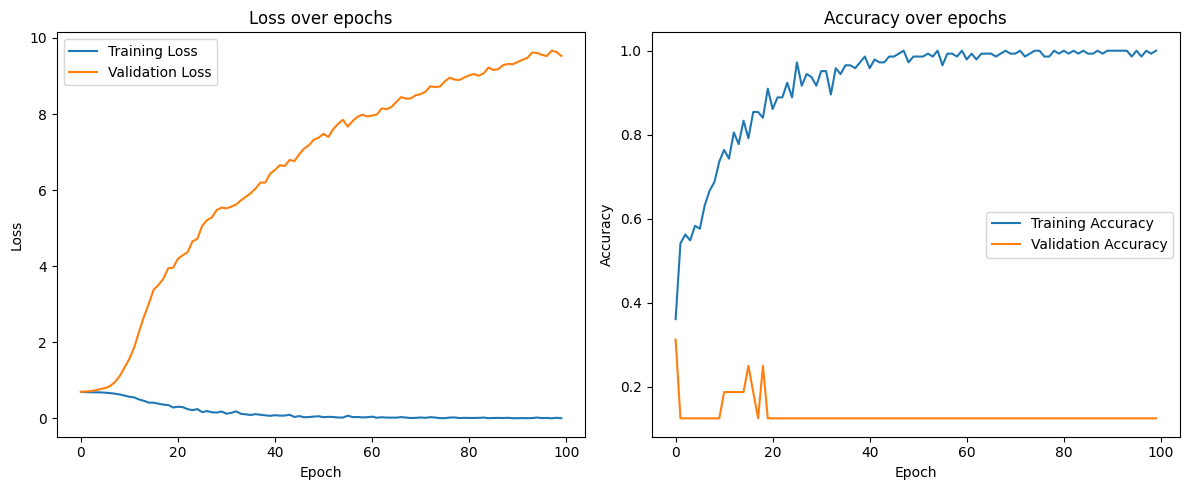

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


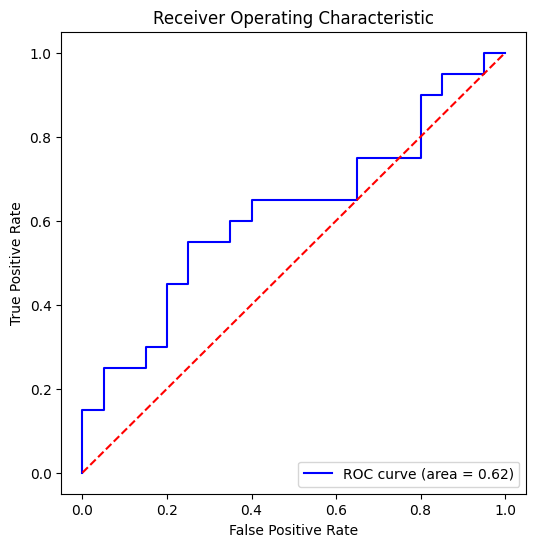

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


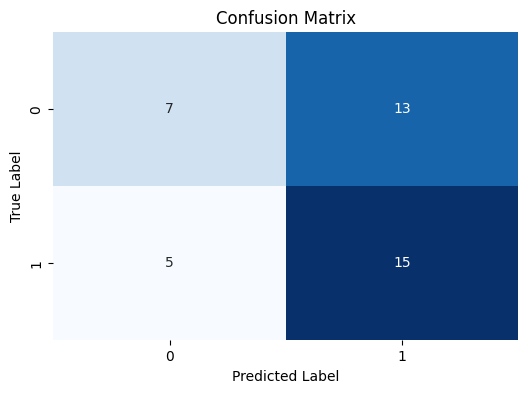

Ressource


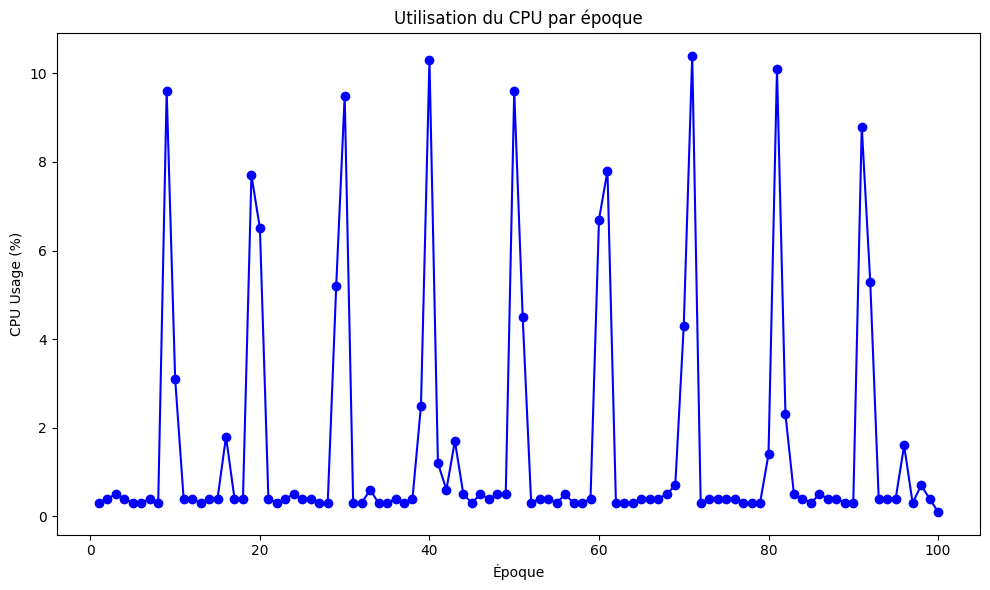

In [46]:
model_zc, history_zc = train_nn(X_train_tfidf.toarray(), train_labels, X_test_tfidf.toarray(), test_labels, epochs=100, batch_size=8)

## Complexe Neural Network

In [47]:
def prepare_data(train_texts, test_texts, vocab_size=10000, padding='post'):
    """
    Tokenise les textes et applique le padding pour obtenir des séquences de même longueur.

    Retourne :
      - X_train_pad, X_test_pad : séquences paddées pour l'entraînement et le test.
      - tokenizer : l'objet Tokenizer entraîné sur les textes d'entraînement.
      - max_length : longueur maximale utilisée pour le padding.
    """
    tokenizer = Tokenizer(num_words=vocab_size)
    tokenizer.fit_on_texts(train_texts)
    X_train_seq = tokenizer.texts_to_sequences(train_texts)
    X_test_seq = tokenizer.texts_to_sequences(test_texts)

    # Définir la longueur maximale basée sur l'ensemble d'entraînement
    max_length = max(len(seq) for seq in X_train_seq)

    X_train_pad = pad_sequences(X_train_seq, maxlen=max_length, padding=padding)
    X_test_pad = pad_sequences(X_test_seq, maxlen=max_length, padding=padding)

    return X_train_pad, X_test_pad, tokenizer, max_length

In [48]:
# Étape 1 : Préparation des données
vocab_size = 10000
embed_dim = 128
X_train_pad, X_test_pad, tokenizer, max_length = prepare_data(train_texts, test_texts, vocab_size=vocab_size)

In [49]:
def train_model(model, X_train, train_labels, X_test, test_labels, epochs=10, batch_size=32):
    """
    Entraîne un modèle déjà défini avec les données fournies, en utilisant un callback
    pour suivre l'utilisation des ressources par époque, et affiche ensuite les métriques d'évaluation.
    """
    resource_monitor = ResourceMonitor()

    with tf.device('/GPU:0'):
        history = model.fit(np.array(X_train), np.array(train_labels),
                        epochs=epochs, batch_size=batch_size,
                        validation_split=0.1, callbacks=[resource_monitor])



    loss, accuracy = model.evaluate(np.array(X_test), np.array(test_labels))
    print("Test Loss:", loss)
    print("Test Accuracy:", accuracy)

    predictions = (model.predict(np.array(X_test)) > 0.5).astype("int32")
    print("\n=== Rapport de Classification ===")
    print(classification_report(np.array(test_labels), predictions))

    conf_matrix = confusion_matrix(np.array(test_labels), predictions)
    precision = precision_score(np.array(test_labels), predictions)
    recall = recall_score(np.array(test_labels), predictions)
    f1 = f1_score(np.array(test_labels), predictions)
    roc_auc = roc_auc_score(np.array(test_labels), model.predict(np.array(X_test)))

    print("Matrice de confusion :\n", conf_matrix)
    print("Précision:", precision)
    print("Recall:", recall)
    print("F1 Score:", f1)
    print("ROC AUC:", roc_auc)

    # Afficher le graphique d'utilisation des ressources
    print('EVALUATION')
    plot_evaluation_graphs(history, model, X_test, test_labels)


    # Afficher le graphique d'utilisation des ressources
    print('Ressource utilisation')
    plot_resource_usage(resource_monitor)

    return history

### RNN

In [50]:
def build_rnn_model_1(vocab_size, embed_dim, max_length):
    """
    Construit et compile un modèle RNN simple pour la classification binaire.

    Paramètres :
      - vocab_size : taille du vocabulaire.
      - embed_dim : dimension de l'embedding.
      - max_length : longueur maximale des séquences.

    Retourne :
      - model : le modèle Keras compilé.
    """
    model = Sequential()
    model.add(Embedding(input_dim=vocab_size, output_dim=embed_dim, input_length=max_length))
    model.add(SimpleRNN(128, activation='tanh'))
    model.add(Dropout(0.5))
    model.add(Dense(1, activation='sigmoid'))

    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return model

In [51]:
def build_rnn_model_2(vocab_size, embed_dim, max_length):
    """
    Construit un modèle RNN complexe pour la classification binaire.

    Paramètres :
      - vocab_size : taille du vocabulaire.
      - embed_dim : dimension de l'embedding.
      - max_length : longueur maximale des séquences (après padding).

    Retourne :
      - model : modèle Keras compilé.
    """
    model = Sequential()
    model.add(Embedding(input_dim=vocab_size, output_dim=embed_dim, input_length=max_length))
    # Couche bidirectionnelle pour capturer les dépendances dans les deux sens
    model.add(Bidirectional(SimpleRNN(128, activation='tanh', return_sequences=True)))
    # Couche récurrente supplémentaire pour résumer la séquence
    model.add(SimpleRNN(64, activation='tanh'))
    model.add(Dropout(0.5))
    # Couches denses pour affiner la représentation
    model.add(Dense(64, activation='relu'))
    model.add(Dropout(0.5))
    # Couche de sortie pour la classification binaire
    model.add(Dense(1, activation='sigmoid'))

    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return model

In [52]:
def build_rnn_model_3(vocab_size, embed_dim, max_length):
    """
    Construit un modèle RNN complexe avec plusieurs couches récurrentes et Dense
    pour la classification binaire.

    Paramètres :
      - vocab_size : taille du vocabulaire.
      - embed_dim : dimension de l'embedding.
      - max_length : longueur maximale des séquences (après padding).

    Retourne :
      - model : modèle Keras compilé.
    """
    model = Sequential()
    # Couche d'embedding
    model.add(Embedding(input_dim=vocab_size, output_dim=embed_dim, input_length=max_length))

    # Première couche récurrente bidirectionnelle avec retour de séquence
    model.add(Bidirectional(SimpleRNN(128, activation='tanh', return_sequences=True)))

    # Deuxième couche récurrente bidirectionnelle avec retour de séquence
    model.add(Bidirectional(SimpleRNN(128, activation='tanh', return_sequences=True)))

    # Troisième couche récurrente pour résumer la séquence
    model.add(SimpleRNN(64, activation='tanh'))

    # Dropout pour éviter le sur-apprentissage
    model.add(Dropout(0.5))

    # Couches denses supplémentaires pour approfondir la représentation
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(64, activation='relu'))
    model.add(Dropout(0.5))

    # Couche de sortie pour la classification binaire
    model.add(Dense(1, activation='sigmoid'))

    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return model


#### training (100 epoch)

##### **complexity 1**

Epoch 1/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 511ms/step - accuracy: 0.4819 - loss: 0.7125Epoch 1 - CPU Usage: 0.3%
5/5 ━━━━━━━━━━━━━━━━━━━━ 8s 903ms/step - accuracy: 0.4873 - loss: 0.7116 - val_accuracy: 0.6250 - val_loss: 0.6622
Epoch 2/100
4/5 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - accuracy: 0.3958 - loss: 0.7827Epoch 2 - CPU Usage: 0.4%
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 294ms/step - accuracy: 0.4213 - loss: 0.7721 - val_accuracy: 0.6250 - val_loss: 0.6630
Epoch 3/100
4/5 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - accuracy: 0.5632 - loss: 0.7122Epoch 3 - CPU Usage: 8.9%
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 293ms/step - accuracy: 0.5699 - loss: 0.7092 - val_accuracy: 0.3750 - val_loss: 0.6936
Epoch 4/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - accuracy: 0.4988 - loss: 0.7829Epoch 4 - CPU Usage: 4.0%
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 296ms/step - accuracy: 0.5001 - loss: 0.7808 - val_accuracy: 0.3750 - val_loss: 0.7794
Epoch 5/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - accuracy: 0.4328 - loss: 0.8103Epoch 5 - CPU Usage:

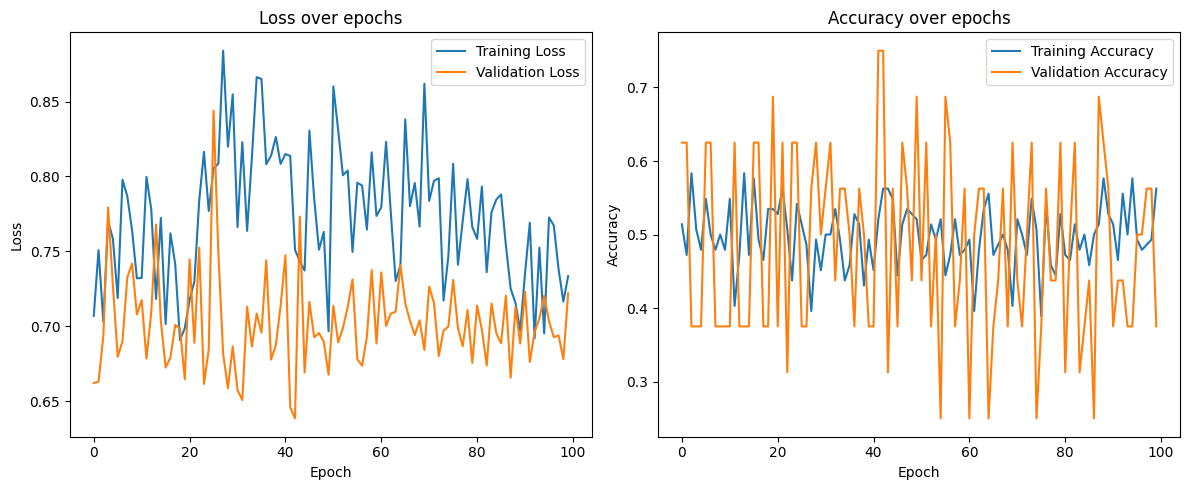

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


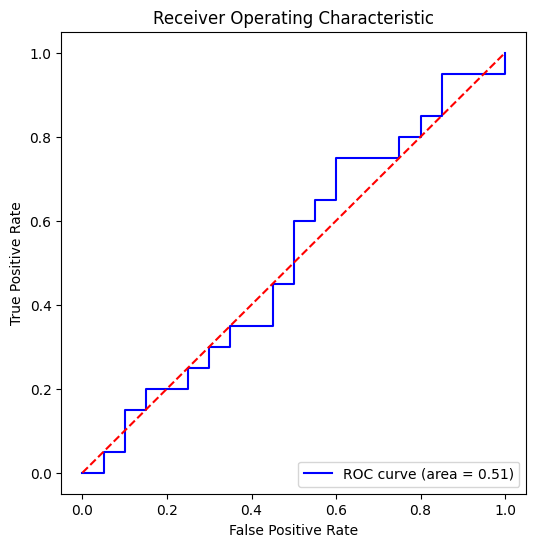

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


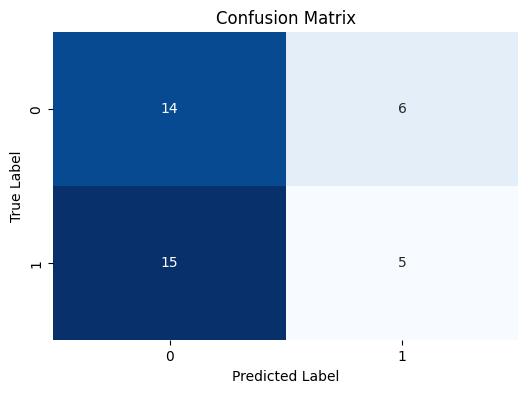

Ressource utilisation


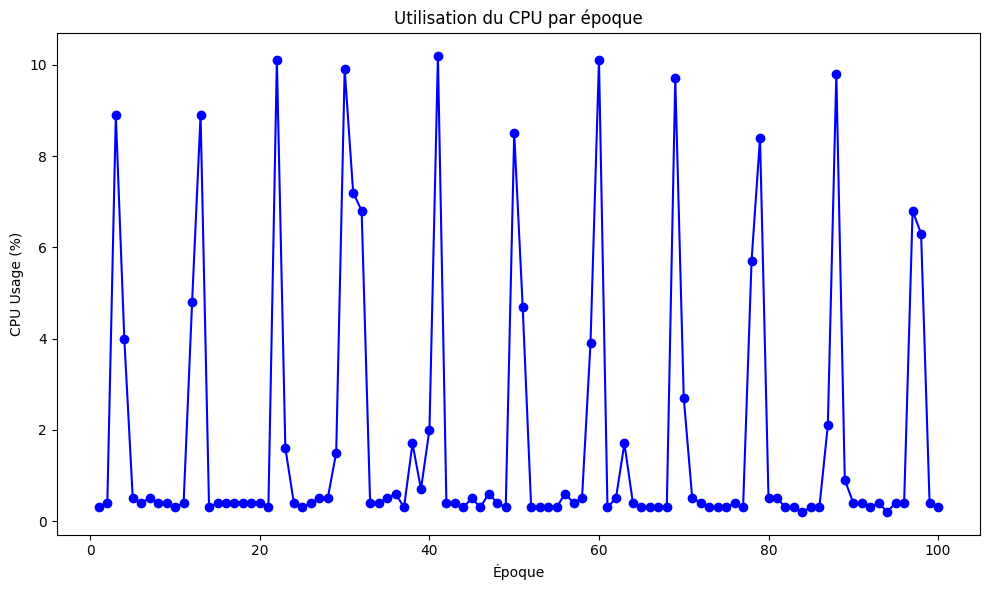

In [53]:
# Étape 3 : Entraînement du modèle avec suivi des ressources
model_rnn_1 = build_rnn_model_1(vocab_size, embed_dim, max_length)
history_rnn_1 = train_model(model_rnn_1, X_train_pad, train_labels, X_test_pad, test_labels, epochs=100, batch_size=32)

##### **complexity 2**


Epoch 1/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 877ms/step - accuracy: 0.4538 - loss: 0.7529Epoch 1 - CPU Usage: 0.4%
5/5 ━━━━━━━━━━━━━━━━━━━━ 13s 1s/step - accuracy: 0.4569 - loss: 0.7557 - val_accuracy: 0.6250 - val_loss: 0.6763
Epoch 2/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step - accuracy: 0.4878 - loss: 0.7464Epoch 2 - CPU Usage: 0.4%
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 344ms/step - accuracy: 0.4841 - loss: 0.7503 - val_accuracy: 0.3750 - val_loss: 0.7625
Epoch 3/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step - accuracy: 0.4991 - loss: 0.7566Epoch 3 - CPU Usage: 0.5%
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 341ms/step - accuracy: 0.4946 - loss: 0.7583 - val_accuracy: 0.3750 - val_loss: 0.7426
Epoch 4/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step - accuracy: 0.5168 - loss: 0.7300Epoch 4 - CPU Usage: 8.7%
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 341ms/step - accuracy: 0.5129 - loss: 0.7310 - val_accuracy: 0.6250 - val_loss: 0.6795
Epoch 5/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step - accuracy: 0.5325 - loss: 0.6971Epoch 5 - CPU Usage: 1

2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 711ms/step

=== Rapport de Classification ===
              precision    recall  f1-score   support

           0       0.50      1.00      0.67        20
           1       0.00      0.00      0.00        20

    accuracy                           0.50        40
   macro avg       0.25      0.50      0.33        40
weighted avg       0.25      0.50      0.33        40

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
Matrice de confusion :
 [[20  0]
 [20  0]]
Précision: 0.0
Recall: 0.0
F1 Score: 0.0
ROC AUC: 0.525
EVALUATION


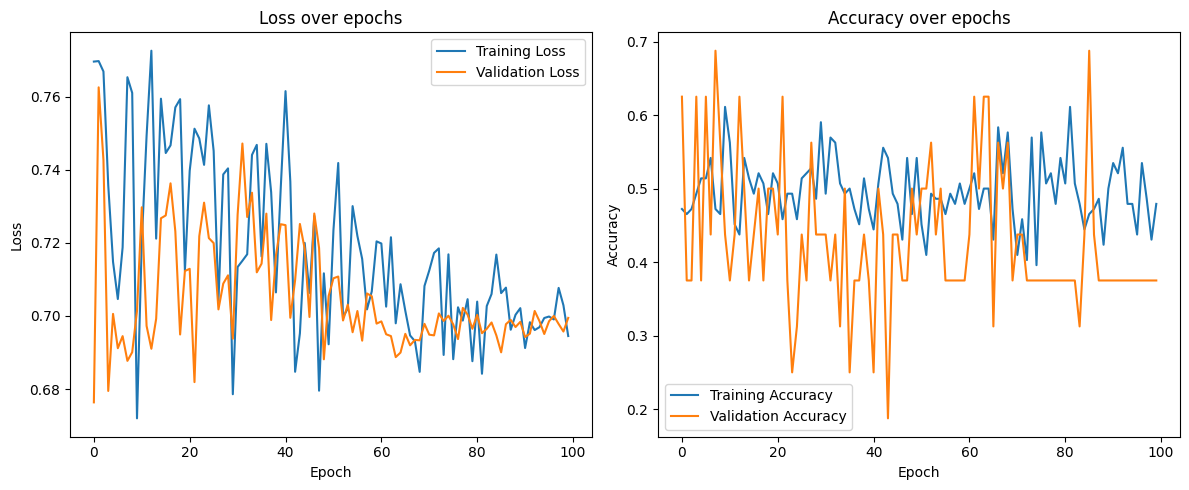

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


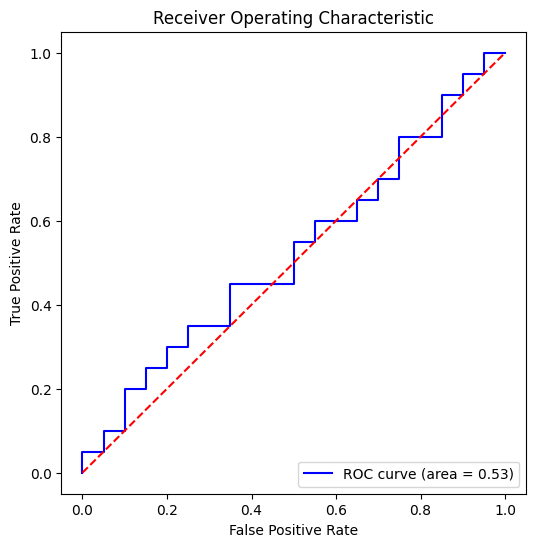

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


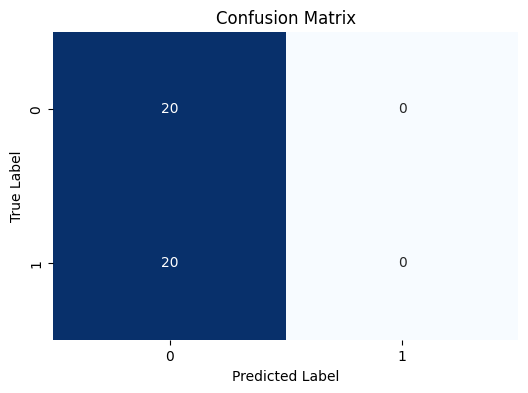

Ressource utilisation


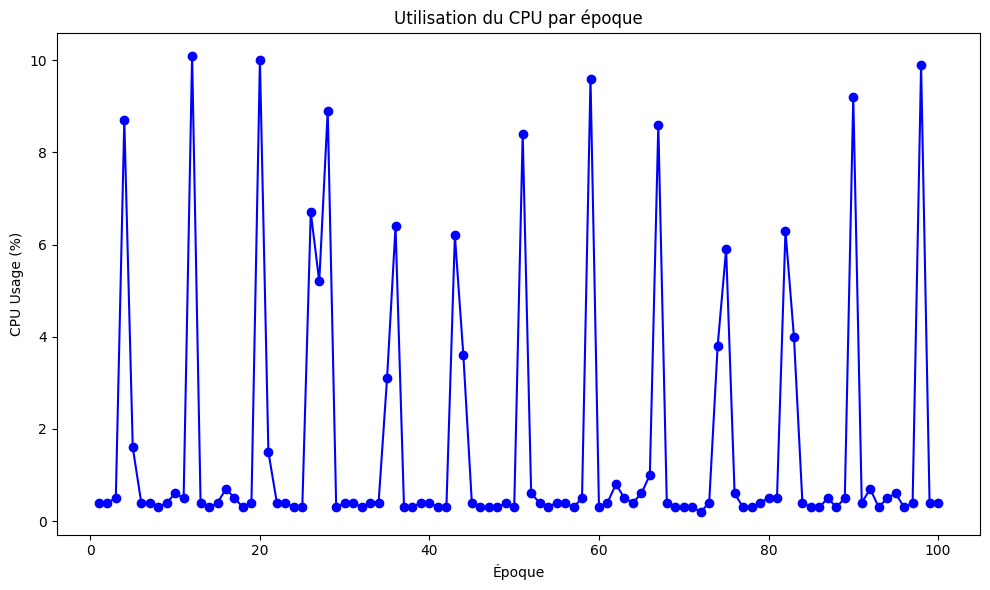

In [54]:
model_rnn_2 = build_rnn_model_2(vocab_size, embed_dim, max_length)
history_rnn_2 = train_model(model_rnn_2, X_train_pad, train_labels, X_test_pad, test_labels, epochs=100, batch_size=32)

#####**Complexity 3**

Epoch 1/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.5965 - loss: 0.7375   Epoch 1 - CPU Usage: 0.3%
5/5 ━━━━━━━━━━━━━━━━━━━━ 20s 2s/step - accuracy: 0.5966 - loss: 0.7369 - val_accuracy: 0.6250 - val_loss: 0.6665
Epoch 2/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 113ms/step - accuracy: 0.4951 - loss: 0.7533Epoch 2 - CPU Usage: 0.3%
5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 391ms/step - accuracy: 0.5006 - loss: 0.7514 - val_accuracy: 0.3750 - val_loss: 0.7159
Epoch 3/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 113ms/step - accuracy: 0.4752 - loss: 0.7995Epoch 3 - CPU Usage: 0.7%
5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 390ms/step - accuracy: 0.4712 - loss: 0.8008 - val_accuracy: 0.3750 - val_loss: 0.7058
Epoch 4/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 113ms/step - accuracy: 0.5024 - loss: 0.8126Epoch 4 - CPU Usage: 0.5%
5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 390ms/step - accuracy: 0.4962 - loss: 0.8155 - val_accuracy: 0.6250 - val_loss: 0.6921
Epoch 5/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 113ms/step - accuracy: 0.4340 - loss: 0.8429Epoch 5 - CPU Usag

2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 1s/step

=== Rapport de Classification ===
              precision    recall  f1-score   support

           0       0.50      1.00      0.67        20
           1       0.00      0.00      0.00        20

    accuracy                           0.50        40
   macro avg       0.25      0.50      0.33        40
weighted avg       0.25      0.50      0.33        40

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
Matrice de confusion :
 [[20  0]
 [20  0]]
Précision: 0.0
Recall: 0.0
F1 Score: 0.0
ROC AUC: 0.5025
EVALUATION


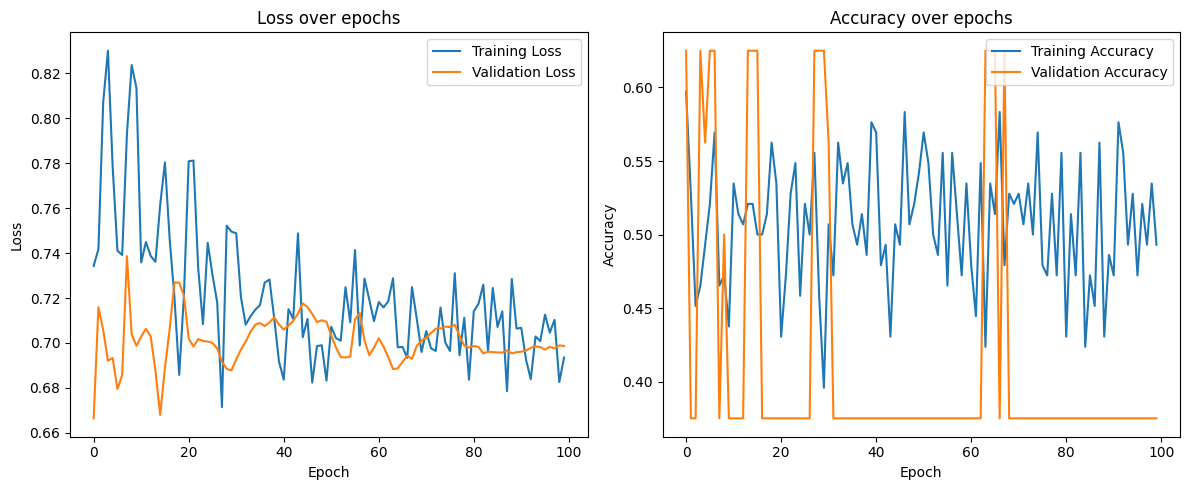

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step


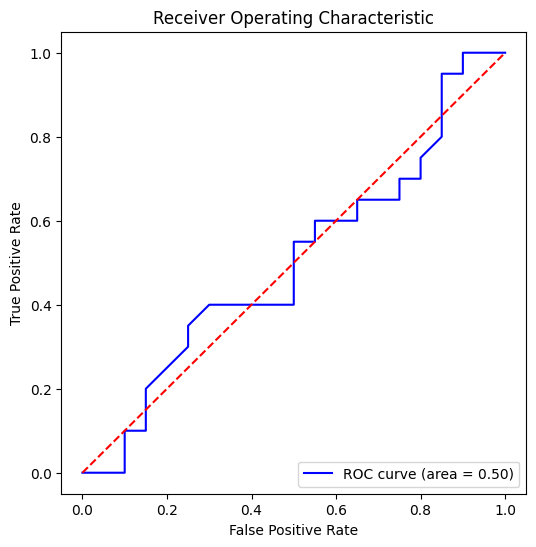

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step


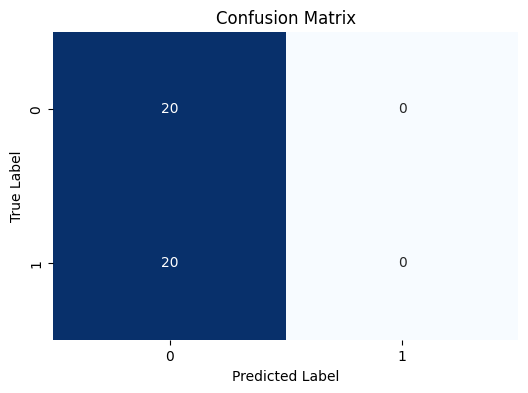

Ressource utilisation


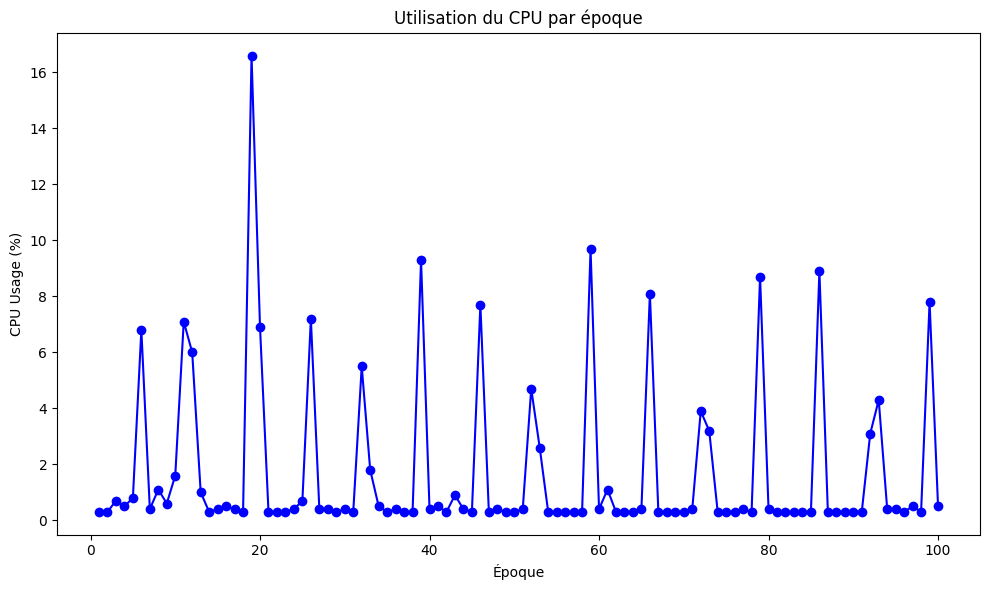

In [55]:
model_rnn_3 = build_rnn_model_3(vocab_size, embed_dim, max_length)
history_rnn_3 = train_model(model_rnn_3, X_train_pad, train_labels, X_test_pad, test_labels, epochs=100, batch_size=32)

##### conclusion

### LSTM

In [56]:
def build_lstm_model_1(vocab_size, embed_dim, max_length):
    """
    Construit et compile un modèle LSTM simple pour la classification binaire.

    Paramètres :
      - vocab_size : taille du vocabulaire.
      - embed_dim : dimension de l'embedding.
      - max_length : longueur maximale des séquences.

    Retourne :
      - model : le modèle Keras compilé.
    """
    model = Sequential()
    model.add(Embedding(input_dim=vocab_size, output_dim=embed_dim, input_length=max_length))
    model.add(LSTM(128))
    model.add(Dropout(0.5))
    model.add(Dense(1, activation='sigmoid'))

    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return model

In [57]:
def build_lstm_model_2(vocab_size, embed_dim, max_length):
    """
    Construit un modèle LSTM complexe pour la classification binaire.

    Paramètres :
      - vocab_size : taille du vocabulaire.
      - embed_dim : dimension de l'embedding.
      - max_length : longueur maximale des séquences (après padding).

    Retourne :
      - model : modèle Keras compilé.
    """
    model = Sequential()
    model.add(Embedding(input_dim=vocab_size, output_dim=embed_dim, input_length=max_length))
    # Première couche LSTM bidirectionnelle avec return_sequences pour empiler une deuxième couche
    model.add(Bidirectional(LSTM(128, return_sequences=True)))
    # Deuxième couche LSTM bidirectionnelle
    model.add(Bidirectional(LSTM(64)))
    model.add(Dropout(0.5))
    model.add(Dense(64, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(1, activation='sigmoid'))

    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return model

In [58]:
def build_lstm_model_3(vocab_size, embed_dim, max_length):
    """
    Construit un modèle LSTM complexe avec plusieurs couches LSTM empilées
    et Dense pour la classification binaire.

    Paramètres :
      - vocab_size : taille du vocabulaire.
      - embed_dim : dimension de l'embedding.
      - max_length : longueur maximale des séquences (après padding).

    Retourne :
      - model : modèle Keras compilé.
    """
    model = Sequential()
    # Couche d'embedding
    model.add(Embedding(input_dim=vocab_size, output_dim=embed_dim, input_length=max_length))

    # Première couche LSTM bidirectionnelle avec retour de séquence
    model.add(Bidirectional(LSTM(128, return_sequences=True)))

    # Deuxième couche LSTM bidirectionnelle avec retour de séquence
    model.add(Bidirectional(LSTM(128, return_sequences=True)))

    # Troisième couche LSTM bidirectionnelle pour résumer la séquence
    model.add(Bidirectional(LSTM(64)))

    # Dropout pour la régularisation
    model.add(Dropout(0.5))

    # Couches denses supplémentaires
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(64, activation='relu'))
    model.add(Dropout(0.5))

    # Couche de sortie pour la classification binaire
    model.add(Dense(1, activation='sigmoid'))

    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return model

#### training (100 epochs)

#####**complexity 1**

Epoch 1/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.4130 - loss: 0.6967Epoch 1 - CPU Usage: 9.5%
5/5 ━━━━━━━━━━━━━━━━━━━━ 5s 365ms/step - accuracy: 0.4136 - loss: 0.6972 - val_accuracy: 0.6250 - val_loss: 0.6888
Epoch 2/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - accuracy: 0.4530 - loss: 0.6955Epoch 2 - CPU Usage: 0.3%
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 296ms/step - accuracy: 0.4550 - loss: 0.6954 - val_accuracy: 0.3750 - val_loss: 0.7070
Epoch 3/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - accuracy: 0.4997 - loss: 0.6948Epoch 3 - CPU Usage: 0.3%
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 295ms/step - accuracy: 0.5020 - loss: 0.6948 - val_accuracy: 0.3750 - val_loss: 0.7094
Epoch 4/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - accuracy: 0.5377 - loss: 0.6897Epoch 4 - CPU Usage: 0.4%
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 296ms/step - accuracy: 0.5337 - loss: 0.6904 - val_accuracy: 0.3750 - val_loss: 0.7051
Epoch 5/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - accuracy: 0.5016 - loss: 0.6959Epoch 5 - CPU Usage: 

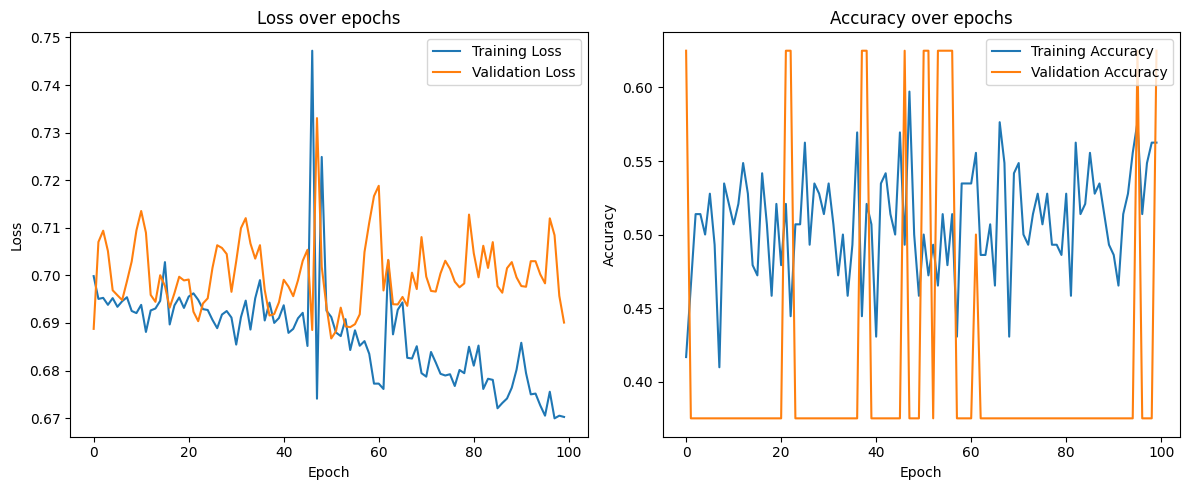

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


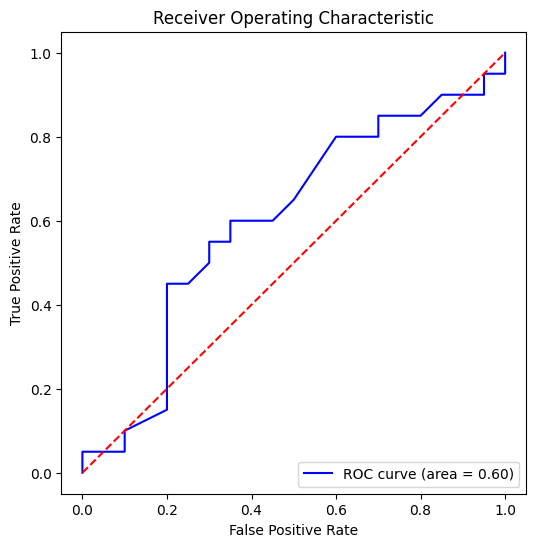

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


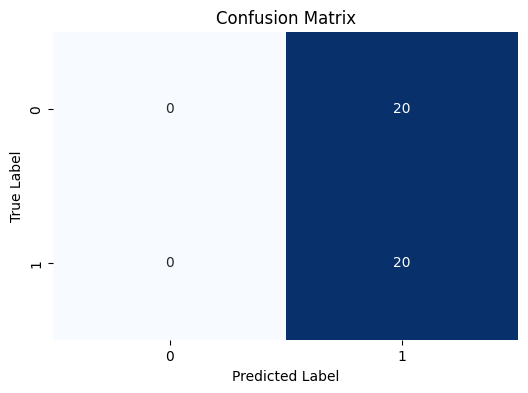

Ressource utilisation


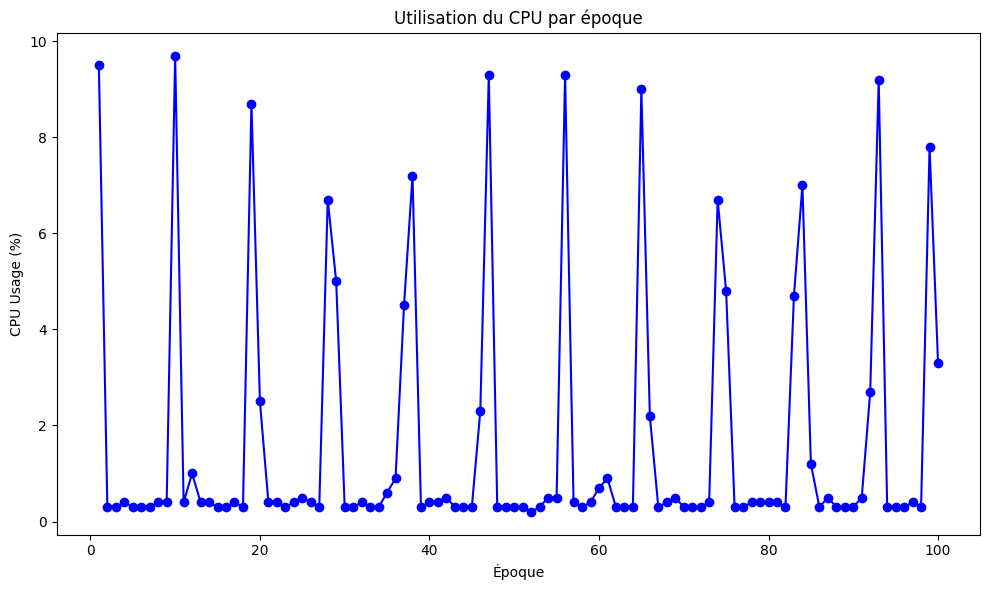

In [59]:
model_lstm_1 = build_lstm_model_1(vocab_size, embed_dim, max_length)
history_lstm_1 = train_model(model_lstm_1, X_train_pad, train_labels, X_test_pad, test_labels, epochs=100, batch_size=32)

#####**Complexity 2**

Epoch 1/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step - accuracy: 0.4481 - loss: 0.6960Epoch 1 - CPU Usage: 0.3%
5/5 ━━━━━━━━━━━━━━━━━━━━ 7s 503ms/step - accuracy: 0.4521 - loss: 0.6961 - val_accuracy: 0.3750 - val_loss: 0.7031
Epoch 2/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step - accuracy: 0.5441 - loss: 0.6891Epoch 2 - CPU Usage: 0.3%
5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 373ms/step - accuracy: 0.5414 - loss: 0.6902 - val_accuracy: 0.3750 - val_loss: 0.7161
Epoch 3/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step - accuracy: 0.4319 - loss: 0.7085Epoch 3 - CPU Usage: 1.0%
5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 372ms/step - accuracy: 0.4387 - loss: 0.7070 - val_accuracy: 0.2500 - val_loss: 0.6973
Epoch 4/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step - accuracy: 0.4363 - loss: 0.6972Epoch 4 - CPU Usage: 2.4%
5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 374ms/step - accuracy: 0.4411 - loss: 0.6966 - val_accuracy: 0.6250 - val_loss: 0.6924
Epoch 5/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/step - accuracy: 0.4444 - loss: 0.7018Epoch 5 - CPU Usage: 

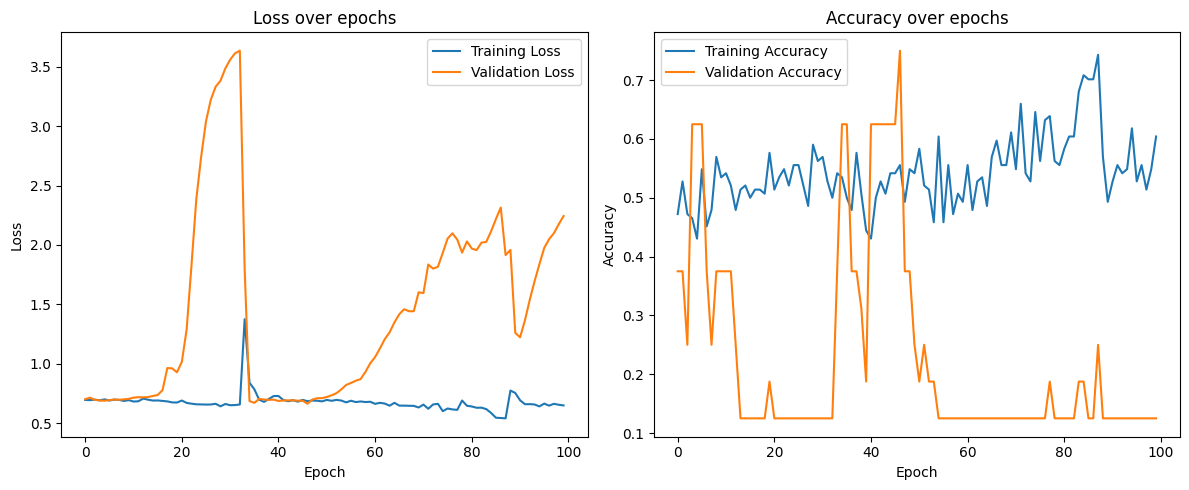

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step


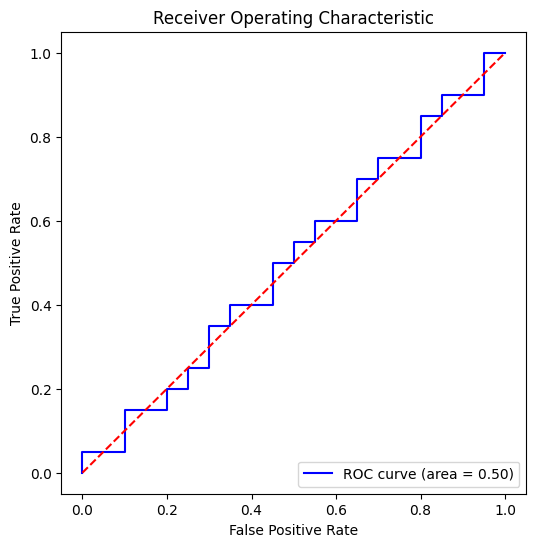

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step


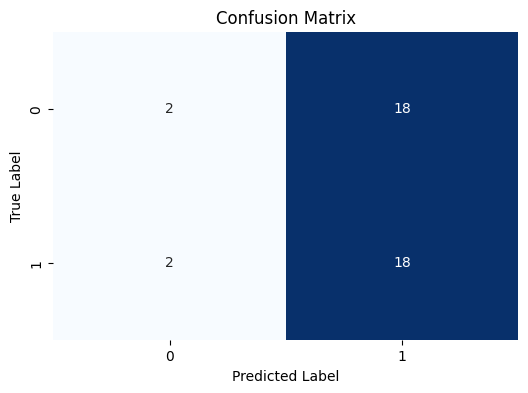

Ressource utilisation


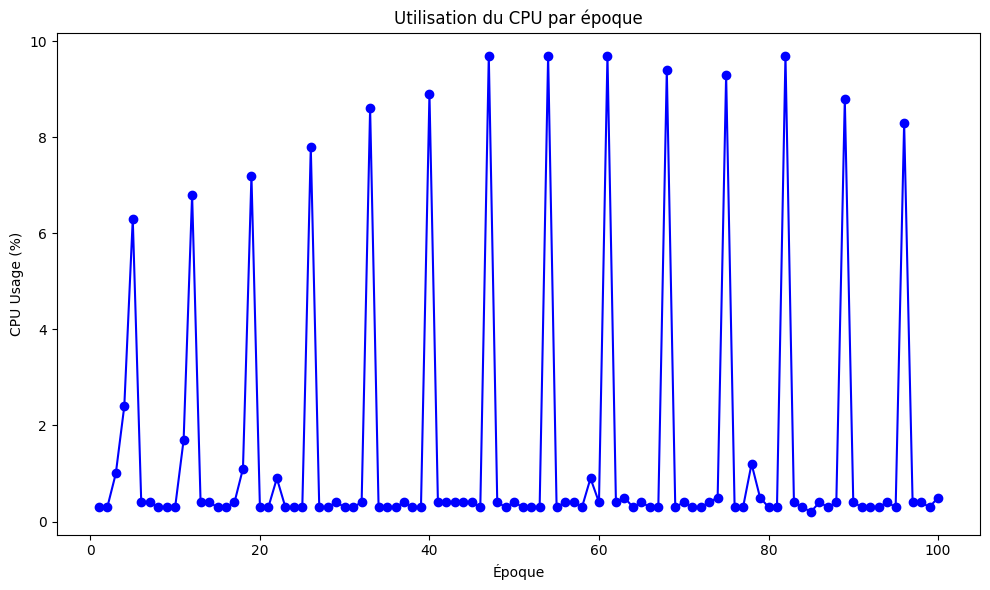

In [60]:
model_lstm_2 = build_lstm_model_2(vocab_size, embed_dim, max_length)
history_lstm_2 = train_model(model_lstm_2, X_train_pad, train_labels, X_test_pad, test_labels, epochs=100, batch_size=32)

#####**Complexity 3**

Epoch 1/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step - accuracy: 0.5493 - loss: 0.6936Epoch 1 - CPU Usage: 0.3%
5/5 ━━━━━━━━━━━━━━━━━━━━ 9s 592ms/step - accuracy: 0.5492 - loss: 0.6936 - val_accuracy: 0.3750 - val_loss: 0.7019
Epoch 2/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step - accuracy: 0.4925 - loss: 0.7005Epoch 2 - CPU Usage: 0.3%
5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 421ms/step - accuracy: 0.4915 - loss: 0.7002 - val_accuracy: 0.3750 - val_loss: 0.6975
Epoch 3/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step - accuracy: 0.4780 - loss: 0.6980Epoch 3 - CPU Usage: 0.3%
5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 421ms/step - accuracy: 0.4828 - loss: 0.6978 - val_accuracy: 0.3750 - val_loss: 0.7016
Epoch 4/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step - accuracy: 0.4910 - loss: 0.6923Epoch 4 - CPU Usage: 9.5%
5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 422ms/step - accuracy: 0.4867 - loss: 0.6939 - val_accuracy: 0.3750 - val_loss: 0.7010
Epoch 5/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step - accuracy: 0.5214 - loss: 0.6928Epoch 5 - CPU Us

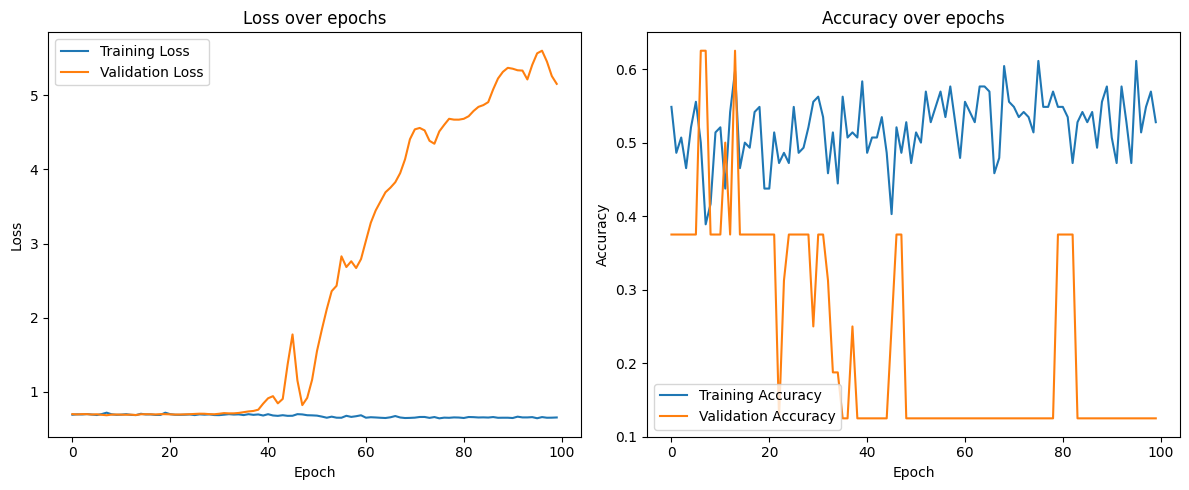

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step


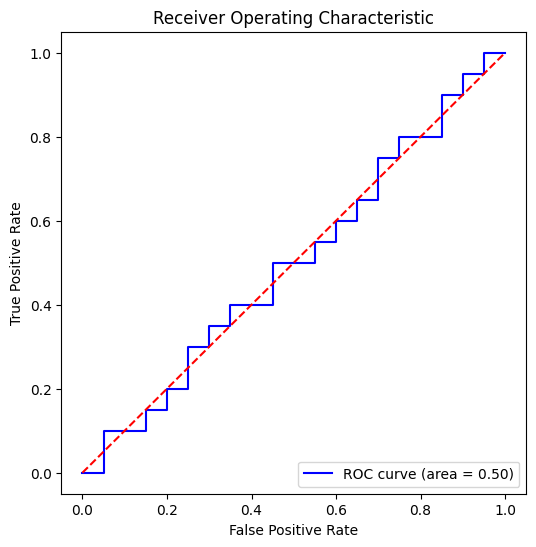

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step


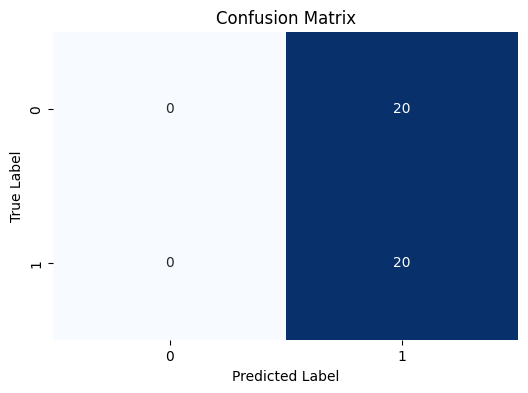

Ressource utilisation


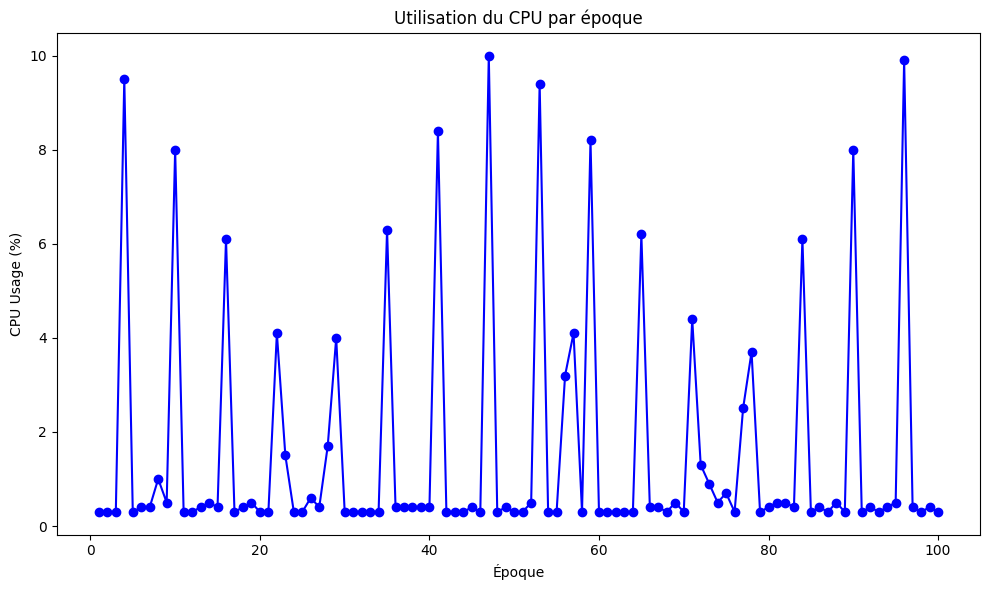

In [61]:
model_lstm_3 = build_lstm_model_3(vocab_size, embed_dim, max_length)
history_lstm_3 = train_model(model_lstm_3, X_train_pad, train_labels, X_test_pad, test_labels, epochs=100, batch_size=32)

# **Transformer**

## Class: **TextDataset**

In [62]:
class TextDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_length=256):
        self.encodings = tokenizer(texts, truncation=True, padding=True, max_length=max_length)
        self.labels = labels

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item['labels'] = torch.tensor(self.labels[idx])
        return item

    def __len__(self):
        return len(self.labels)

## evaluation metrics

In [63]:
def compute_metrics(pred):
    labels = pred.label_ids
    preds = np.argmax(pred.predictions, axis=1)
    acc = accuracy_score(labels, preds)
    precision, recall, f1, _ = precision_recall_fscore_support(labels, preds, average='binary')
    return {"accuracy": acc, "precision": precision, "recall": recall, "f1": f1}


## load dataset

In [64]:
def load_model_and_tokenizer(model_id, num_labels=2):
    """
    Charge le modèle pré-entraîné et le tokenizer correspondant.
    """
    tokenizer = AutoTokenizer.from_pretrained(model_id)
    model = AutoModelForSequenceClassification.from_pretrained(model_id, num_labels=num_labels)
    return model, tokenizer

## create dataset

In [65]:
def create_datasets(train_texts, train_labels, test_texts, test_labels, tokenizer, max_length=256):
    """
    Crée les datasets d'entraînement et de test.
    """
    train_dataset = TextDataset(train_texts, train_labels, tokenizer, max_length)
    test_dataset = TextDataset(test_texts, test_labels, tokenizer, max_length)
    return train_dataset, test_dataset

## Finetune

In [66]:
def fine_tune_model(model_id, train_texts, train_labels, test_texts, test_labels, training_args, max_length=256):
    """
    Fine-tune un modèle Transformer pour la classification de textes.

    Retourne :
      - eval_results : résultats d'évaluation après entraînement.
      - model : modèle fine-tuné.
      - trainer : instance du Trainer utilisée.
    """
    model, tokenizer = load_model_and_tokenizer(model_id)
    train_dataset, test_dataset = create_datasets(train_texts, train_labels, test_texts, test_labels, tokenizer, max_length)

    trainer = Trainer(
        model=model,
        args=training_args,
        train_dataset=train_dataset,
        eval_dataset=test_dataset,
        compute_metrics=compute_metrics,
    )

    trainer.train()
    eval_results = trainer.evaluate()
    return eval_results, model, trainer

## Test model

In [67]:
def test_models(model_dict, train_texts, train_labels, test_texts, test_labels, training_args, max_length=256):
    """
    Itère sur un dictionnaire de modèles et fine-tune chacun d'entre eux.

    Paramètres :
      - model_dict : dictionnaire avec comme clés les identifiants de modèle et comme valeurs des étiquettes lisibles.
      - train_texts, train_labels, test_texts, test_labels : données de classification.
      - training_args : arguments d'entraînement pour Hugging Face Trainer.
      - max_length : longueur maximale pour le padding des séquences.

    Retourne un dictionnaire de résultats d'évaluation pour chaque modèle.
    """
    results = {}
    for model_id, model_label in model_dict.items():
        print("\n==============================================")
        print("Fine-tuning du modèle :", model_label)
        print("==============================================")
        eval_results, model, trainer = fine_tune_model(
            model_id, train_texts, train_labels, test_texts, test_labels, training_args, max_length
        )
        print(f"Résultats d'évaluation pour {model_label} :", eval_results)
        results[model_label] = eval_results
    return results

## config

In [68]:
from transformers import TrainingArguments

training_args = TrainingArguments(
    output_dir='./results',
    num_train_epochs=100,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=64,
    evaluation_strategy="epoch",
    save_strategy="epoch",          # Ajouté pour correspondre à evaluation_strategy
    logging_dir='./logs',
    logging_steps=10,
    load_best_model_at_end=True,
    metric_for_best_model="accuracy"
)

# Dictionnaire des modèles à tester
model_names = {
    "bert-base-uncased": "BERT",
    "distilbert-base-uncased": "DistilBERT",
    "roberta-base": "RoBERTa"
}

In [69]:

for model_id, model_label in model_names.items():
    print("\n==============================================")
    print("Fine-tuning du modèle :", model_label)
    print("==============================================")

    # Chargement du tokenizer et du modèle pré-entraîné
    tokenizer = AutoTokenizer.from_pretrained(model_id)
    model = AutoModelForSequenceClassification.from_pretrained(model_id, num_labels=2)

    # Préparation des datasets
    train_dataset = TextDataset(train_texts, train_labels, tokenizer, max_length=256)
    test_dataset  = TextDataset(test_texts, test_labels, tokenizer, max_length=256)

    # Création du Trainer
    trainer = Trainer(
        model=model,
        args=training_args,
        train_dataset=train_dataset,
        eval_dataset=test_dataset,
        compute_metrics=compute_metrics,
    )

    # Fine-tuning
    trainer.train()

    # Évaluation
    eval_results = trainer.evaluate()
    print(f"Résultats d'évaluation pour {model_label} :", eval_results)


Fine-tuning du modèle : BERT


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
wandb: WARNING The `run_name` is currently set to the same value as `TrainingArguments.output_dir`. If this was not intended, please specify a different run name by setting the `TrainingArguments.run_name` parameter.
wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.


<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter:

 ··········


wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: No netrc file found, creating one.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: bokambaregis to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


Résultats d'évaluation pour BERT : {'eval_loss': 1.7469031810760498, 'eval_accuracy': 0.775, 'eval_precision': 0.7619047619047619, 'eval_recall': 0.8, 'eval_f1': 0.7804878048780488, 'eval_runtime': 0.2498, 'eval_samples_per_second': 160.135, 'eval_steps_per_second': 4.003, 'epoch': 100.0}

Fine-tuning du modèle : DistilBERT


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Résultats d'évaluation pour DistilBERT : {'eval_loss': 1.4526172876358032, 'eval_accuracy': 0.775, 'eval_precision': 0.8235294117647058, 'eval_recall': 0.7, 'eval_f1': 0.7567567567567568, 'eval_runtime': 0.1244, 'eval_samples_per_second': 321.494, 'eval_steps_per_second': 8.037, 'epoch': 100.0}

Fine-tuning du modèle : RoBERTa


tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/481 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/499M [00:00<?, ?B/s]

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Résultats d'évaluation pour RoBERTa : {'eval_loss': 0.6581660509109497, 'eval_accuracy': 0.675, 'eval_precision': 1.0, 'eval_recall': 0.35, 'eval_f1': 0.5185185185185185, 'eval_runtime': 0.2446, 'eval_samples_per_second': 163.519, 'eval_steps_per_second': 4.088, 'epoch': 100.0}


# Bigger Dataset

In [70]:
! git clone https://github.com/gyxcit/nlp_course1

Cloning into 'nlp_course1'...
remote: Enumerating objects: 66, done.
remote: Counting objects: 100% (66/66), done.
remote: Compressing objects: 100% (61/61), done.
remote: Total 66 (delta 30), reused 11 (delta 3), pack-reused 0 (from 0)
Receiving objects: 100% (66/66), 11.16 MiB | 13.17 MiB/s, done.
Resolving deltas: 100% (30/30), done.


In [71]:
path_dataset="/content/nlp_course1/combined_dataset.csv"

In [72]:
dfb=pd.read_csv(path_dataset)
dfb["label"].value_counts()

label
1    6250
0    6250
Name: count, dtype: int64

In [73]:
dfb["status"].value_counts()

status
train    10000
test      2500
Name: count, dtype: int64

In [74]:
dfb=dfb.sample(300)

## spliting datasest

In [75]:
# Filtrer les données pour le training
train_data = dfb[dfb['status'] == 'train']

# Filtrer les données pour les tests
test_data = dfb[dfb['status'] == 'test']

# Extraire les colonnes nécessaires
train_texts_b = train_data['text'].tolist()
train_labels_b = train_data['label'].tolist()
test_texts_b = test_data['text'].tolist()
test_labels_b = test_data['label'].tolist()

In [76]:
len(train_texts_b), len(train_labels_b), len(test_texts_b), len(test_labels_b)

(239, 239, 61, 61)

## Analysis

=== Analyse sur tous les labels ===


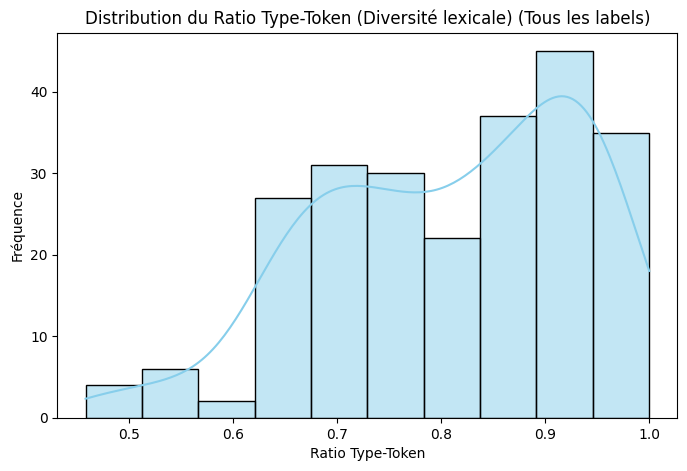

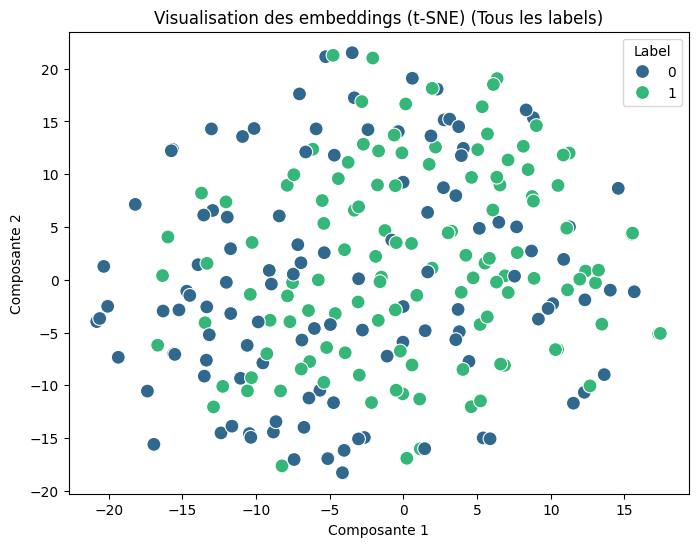

Topics extraits par NMF (Tous les labels):
Topic 1: patients, health, data, risk, influenza, disease, clinical, severe, public, factors
Topic 2: viral, cell, cells, virus, protein, proteins, host, infection, hiv, viruses


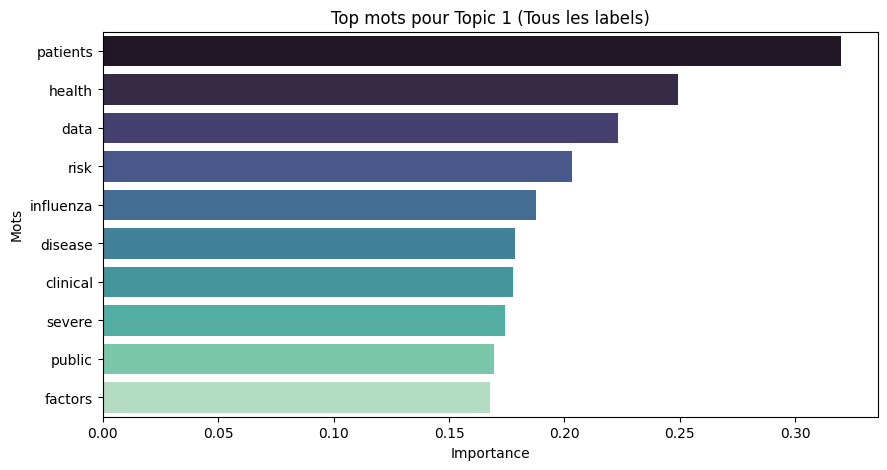

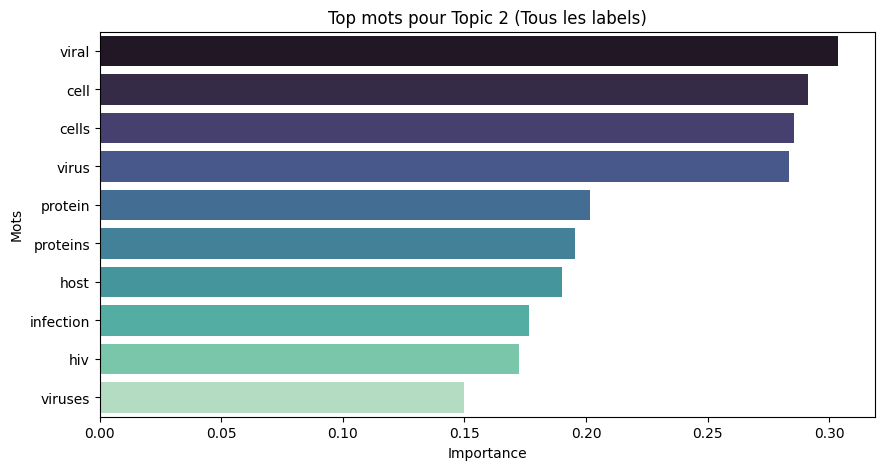

=== Analyse pour le label 0 ===


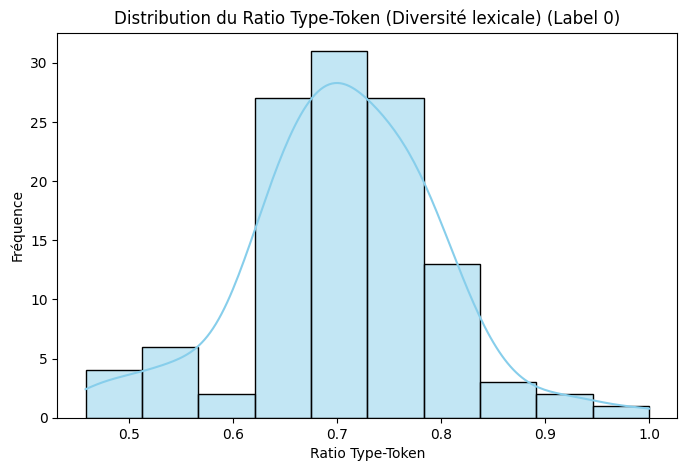

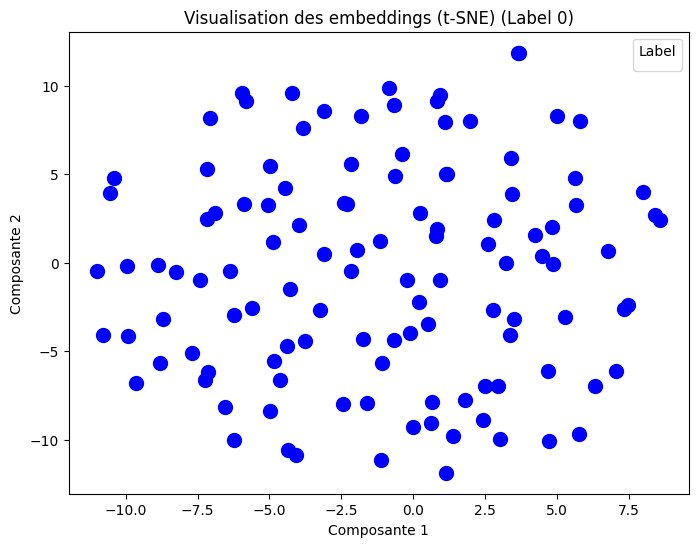

Topics extraits par NMF (Label 0):
Topic 1: cell, viral, virus, cells, proteins, infection, protein, host, fusion, immune
Topic 2: patients, pneumonia, severe, outbreaks, data, median, hiv, influenza, risk, icu


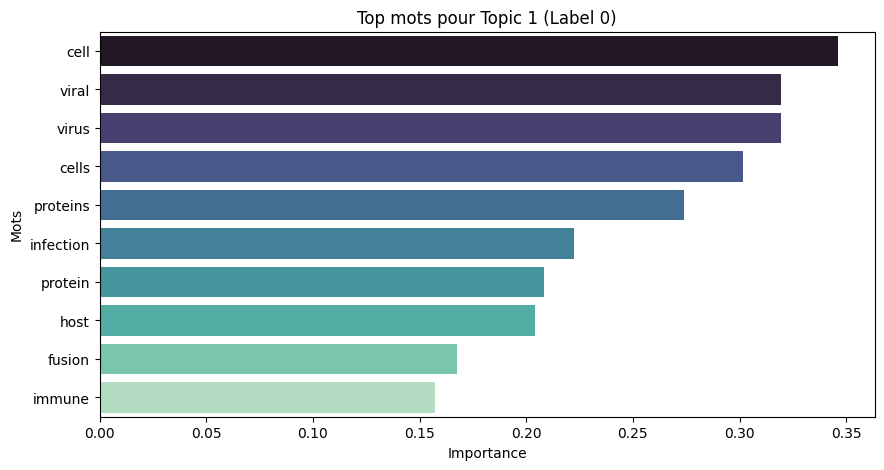

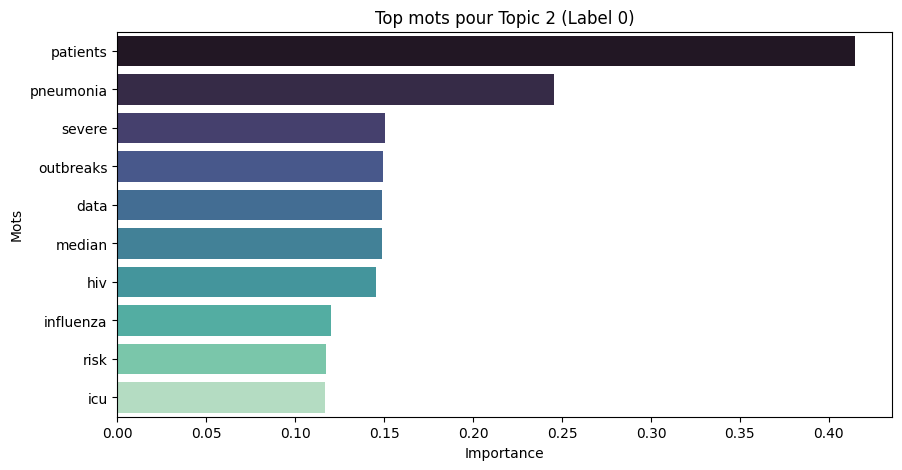

=== Analyse pour le label 1 ===


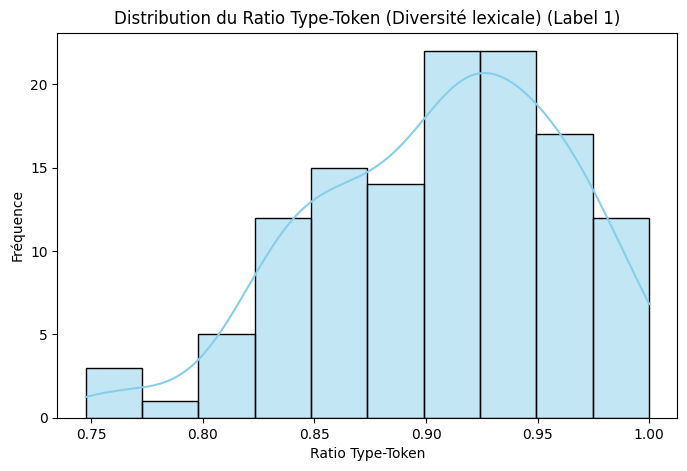

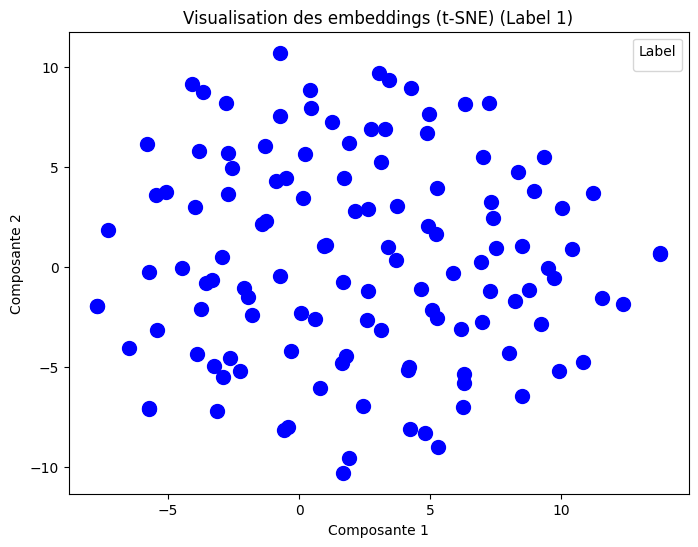

Topics extraits par NMF (Label 1):
Topic 1: health, patients, public, data, risk, influenza, clinical, infection, factors, mortality
Topic 2: viral, cells, virus, protein, cell, mechanisms, molecular, hiv, pathways, viruses


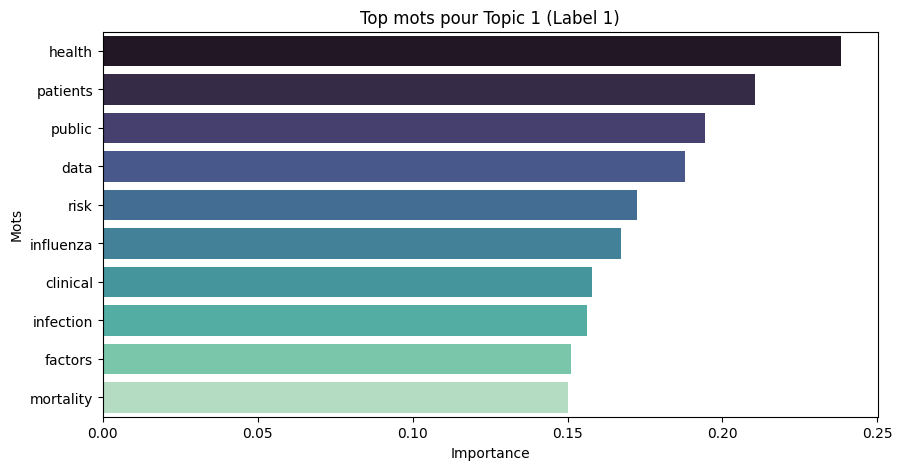

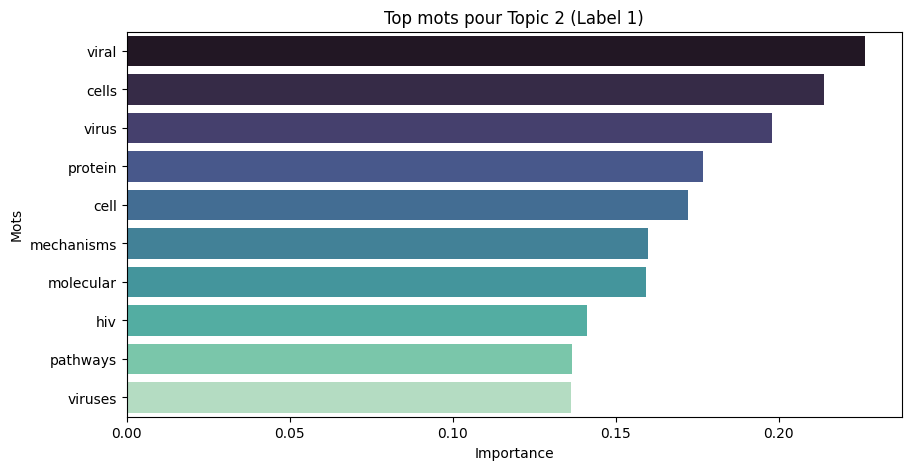

In [77]:
#analyse training
dfb_tr=dfb[dfb['status']=='train']

for filter_val in [None, 0, 1]:
    if filter_val is None:
        print("=== Analyse sur tous les labels ===")
    else:
        print(f"=== Analyse pour le label {filter_val} ===")

    plot_ttr_distribution(dfb_tr, label_filter=filter_val)

    plot_tsne(dfb_tr, label_filter=filter_val)

    plot_topic_modeling(dfb_tr, n_topics=2, label_filter=filter_val)

## Quick comparaison Lazypredict

### new tfidf & bow

In [78]:
# Instanciation du vectorizer
vectorizer_tfidf = TfidfVectorizer()
vectorizer_bow = CountVectorizer()

# Transformation des textes d'entraînement et de test
X_train_tfidf_b = vectorizer_tfidf.fit_transform(train_texts_b)
X_test_tfidf_b = vectorizer_tfidf.transform(test_texts_b)

X_train_bow_b = vectorizer_bow.fit_transform(train_texts_b)
X_test_bow_b = vectorizer_bow.transform(test_texts_b)


print("Taille de la matrice d'entraînement (bag-of-words) :", X_train_bow_b.shape)
print("Taille de la matrice d'entraînement (TF-IDF) :", X_train_tfidf_b.shape)

Taille de la matrice d'entraînement (bag-of-words) : (239, 6505)
Taille de la matrice d'entraînement (TF-IDF) : (239, 6505)


### models comparaison

####tfidf

In [79]:
tfidf_models_b,tfidf_predictions_b=training(X_train_tfidf_b, X_test_tfidf_b, train_labels_b, test_labels_b)
tfidf_models_b

Utilisation du CPU avant entraînement: 1.2 %
Mémoire virtuelle avant entraînement: svmem(total=56866914304, available=51119509504, percent=10.1, used=5058461696, free=439345152, active=1724350464, inactive=51884417024, buffers=421683200, cached=50947424256, shared=28426240, slab=2355265536)


100%|██████████| 32/32 [00:09<00:00,  3.27it/s]

[LightGBM] [Info] Number of positive: 123, number of negative: 116
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000731 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1682
[LightGBM] [Info] Number of data points in the train set: 239, number of used features: 131
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.514644 -> initscore=0.058594
[LightGBM] [Info] Start training from score 0.058594
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf

Utilisation du CPU après entraînement: 0.5 %
Mémoire virtuelle après entraînement: svmem(total=56866914304, available=50956423168, percent=10.4, used=5221535744, free=439562240, active=1752678400, inactive=51874942976, buffers=421732352, cached=50784083968, shared=28426240, slab=2351554560)


Accuracy  Balanced Accuracy  ROC AUC  F1 Score  \
Model                                                                           
RandomForestClassifier             0.90               0.90     0.90      0.90   
XGBClassifier                      0.89               0.89     0.89      0.89   
ExtraTreesClassifier               0.90               0.89     0.89      0.90   
LGBMClassifier                     0.85               0.86     0.86      0.85   
AdaBoostClassifier                 0.85               0.86     0.86      0.85   
PassiveAggressiveClassifier        0.80               0.80     0.80      0.80   
RidgeClassifier                    0.80               0.79     0.79      0.80   
RidgeClassifierCV                  0.80               0.79     0.79      0.80   
LinearSVC                          0.80               0.79     0.79      0.80   
LogisticRegression                 0.80               0.79     0.79      0.80   
BaggingClassifier                  0.79               0.78     0.78      0.79   
NearestCentroid                    0.79               0.77     0.77      0.78   
SGDClassifier                      0.79               0.77     0.77      0.78   
Perceptron                         0.79               0.77     0.77      0.78   
BernoulliNB                        0.79               0.77     0.77      0.78   
CalibratedClassifierCV             0.79               0.77     0.77      0.78   
DecisionTreeClassifier             0.70               0.69     0.69      0.70   
NuSVC                              0.64               0.67     0.67      0.61   
SVC                                0.61               0.64     0.64      0.58   
LinearDiscriminantAnalysis         0.64               0.61     0.61      0.61   
ExtraTreeClassifier                0.62               0.61     0.61      0.62   
GaussianNB                         0.57               0.58     0.58      0.57   
KNeighborsClassifier               0.52               0.51     0.51      0.52   
LabelPropagation                   0.44               0.50     0.50      0.27   
DummyClassifier                    0.56               0.50     0.50      0.40   
LabelSpreading                     0.44               0.50     0.50      0.27   
QuadraticDiscriminantAnalysis      0.46               0.45     0.45      0.45   

                               Time Taken  
Model                                      
RandomForestClassifier               0.40  
XGBClassifier                        0.58  
ExtraTreesClassifier                 0.42  
LGBMClassifier                       0.25  
AdaBoostClassifier                   0.86  
PassiveAggressiveClassifier          0.18  
RidgeClassifier                      0.19  
RidgeClassifierCV                    0.46  
LinearSVC                            0.39  
LogisticRegression                   0.23  
BaggingClassifier                    0.45  
NearestCentroid                      0.20  
SGDClassifier                        0.20  
Perceptron                           0.21  
BernoulliNB                          0.19  
CalibratedClassifierCV               0.76  
DecisionTreeClassifier               0.19  
NuSVC                                0.38  
SVC                                  0.44  
LinearDiscriminantAnalysis           0.66  
ExtraTreeClassifier                  0.13  
GaussianNB                           0.15  
KNeighborsClassifier                 0.14  
LabelPropagation                     0.15  
DummyClassifier                      0.13  
LabelSpreading                       0.20  
QuadraticDiscriminantAnalysis        0.46

#### bow


In [80]:
bow_models_b,bow_predictions_b=training(X_train_bow_b, X_test_bow_b, train_labels_b, test_labels_b)
bow_models_b

Utilisation du CPU avant entraînement: 0.6 %
Mémoire virtuelle avant entraînement: svmem(total=56866914304, available=50954981376, percent=10.4, used=5222977536, free=438054912, active=1752678400, inactive=51874975744, buffers=421732352, cached=50784149504, shared=28426240, slab=2351558656)


100%|██████████| 32/32 [00:09<00:00,  3.33it/s]

[LightGBM] [Info] Number of positive: 123, number of negative: 116
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000720 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 602
[LightGBM] [Info] Number of data points in the train set: 239, number of used features: 131
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.514644 -> initscore=0.058594
[LightGBM] [Info] Start training from score 0.058594
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


Utilisation du CPU après entraînement: 0.6 %
Mémoire virtuelle après entraînement: svmem(total=56866914304, available=50899230720, percent=10.5, used=5278740480, free=382058496, active=1752756224, inactive=51911888896, buffers=421797888, cached=50784317440, shared=28426240, slab=2351456256)


Accuracy  Balanced Accuracy  ROC AUC  F1 Score  \
Model                                                                           
ExtraTreesClassifier               0.90               0.90     0.90      0.90   
AdaBoostClassifier                 0.87               0.87     0.87      0.87   
XGBClassifier                      0.85               0.85     0.85      0.85   
RandomForestClassifier             0.85               0.84     0.84      0.85   
BernoulliNB                        0.79               0.77     0.77      0.78   
SVC                                0.77               0.76     0.76      0.77   
NuSVC                              0.77               0.76     0.76      0.77   
BaggingClassifier                  0.75               0.75     0.75      0.75   
PassiveAggressiveClassifier        0.75               0.73     0.73      0.74   
LGBMClassifier                     0.72               0.72     0.72      0.72   
Perceptron                         0.72               0.70     0.70      0.71   
LinearSVC                          0.72               0.69     0.69      0.70   
LogisticRegression                 0.72               0.69     0.69      0.70   
NearestCentroid                    0.70               0.68     0.68      0.68   
RidgeClassifier                    0.70               0.67     0.67      0.68   
RidgeClassifierCV                  0.70               0.67     0.67      0.68   
DecisionTreeClassifier             0.67               0.67     0.67      0.67   
CalibratedClassifierCV             0.69               0.66     0.66      0.66   
SGDClassifier                      0.67               0.64     0.64      0.64   
ExtraTreeClassifier                0.62               0.61     0.61      0.62   
LinearDiscriminantAnalysis         0.61               0.58     0.58      0.58   
GaussianNB                         0.54               0.53     0.53      0.54   
DummyClassifier                    0.56               0.50     0.50      0.40   
LabelPropagation                   0.44               0.50     0.50      0.27   
KNeighborsClassifier               0.56               0.50     0.50      0.40   
LabelSpreading                     0.44               0.50     0.50      0.27   
QuadraticDiscriminantAnalysis      0.41               0.43     0.43      0.39   

                               Time Taken  
Model                                      
ExtraTreesClassifier                 0.42  
AdaBoostClassifier                   0.81  
XGBClassifier                        0.50  
RandomForestClassifier               0.43  
BernoulliNB                          0.17  
SVC                                  0.41  
NuSVC                                0.39  
BaggingClassifier                    0.47  
PassiveAggressiveClassifier          0.18  
LGBMClassifier                       0.24  
Perceptron                           0.21  
LinearSVC                            0.43  
LogisticRegression                   0.23  
NearestCentroid                      0.20  
RidgeClassifier                      0.22  
RidgeClassifierCV                    0.43  
DecisionTreeClassifier               0.18  
CalibratedClassifierCV               0.71  
SGDClassifier                        0.21  
ExtraTreeClassifier                  0.14  
LinearDiscriminantAnalysis           0.60  
GaussianNB                           0.15  
DummyClassifier                      0.13  
LabelPropagation                     0.17  
KNeighborsClassifier                 0.14  
LabelSpreading                       0.20  
QuadraticDiscriminantAnalysis        0.44

## Neural Network

### Simple

=== Début de l'entraînement ===
Epoch 1/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - accuracy: 0.4992 - loss: 0.6934Epoch 1 - CPU Usage: 1.3%
27/27 ━━━━━━━━━━━━━━━━━━━━ 4s 89ms/step - accuracy: 0.5009 - loss: 0.6933 - val_accuracy: 0.5833 - val_loss: 0.6860
Epoch 2/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7795 - loss: 0.6537 Epoch 2 - CPU Usage: 0.4%
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 43ms/step - accuracy: 0.7811 - loss: 0.6531 - val_accuracy: 0.7917 - val_loss: 0.6348
Epoch 3/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9279 - loss: 0.5207 Epoch 3 - CPU Usage: 0.3%
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 43ms/step - accuracy: 0.9285 - loss: 0.5186 - val_accuracy: 0.8750 - val_loss: 0.4968
Epoch 4/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9725 - loss: 0.2409 Epoch 4 - CPU Usage: 0.3%
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 43ms/step - accuracy: 0.9730 - loss: 0.2387 - val_accuracy: 0.9167 - val_loss: 0.3477
Epoch 5/100
26/27 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accurac

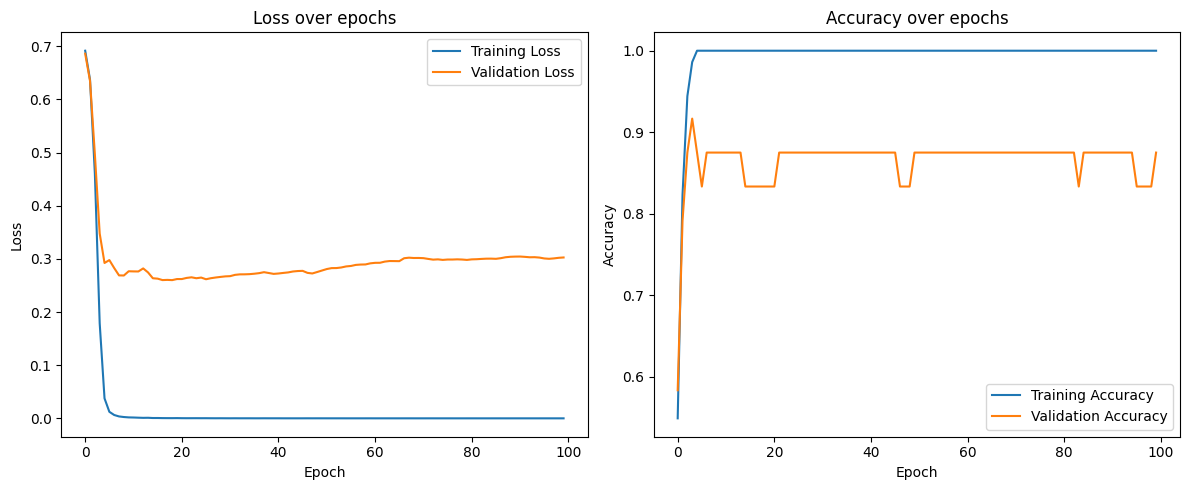

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


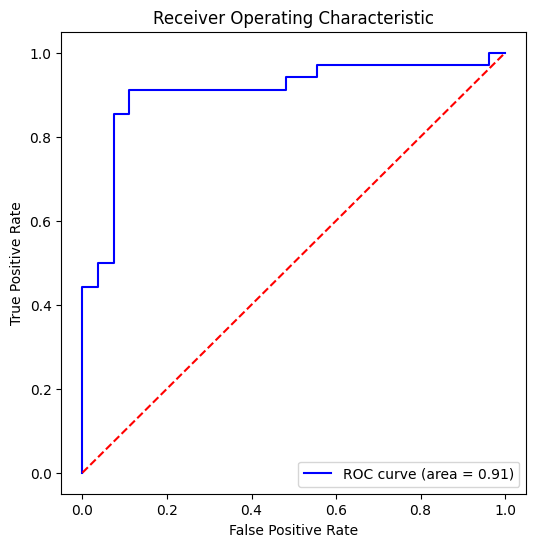

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


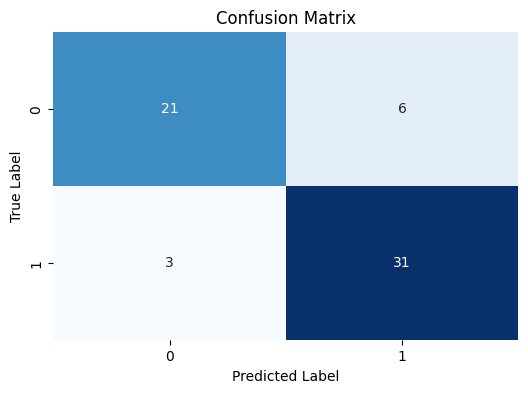

Ressource


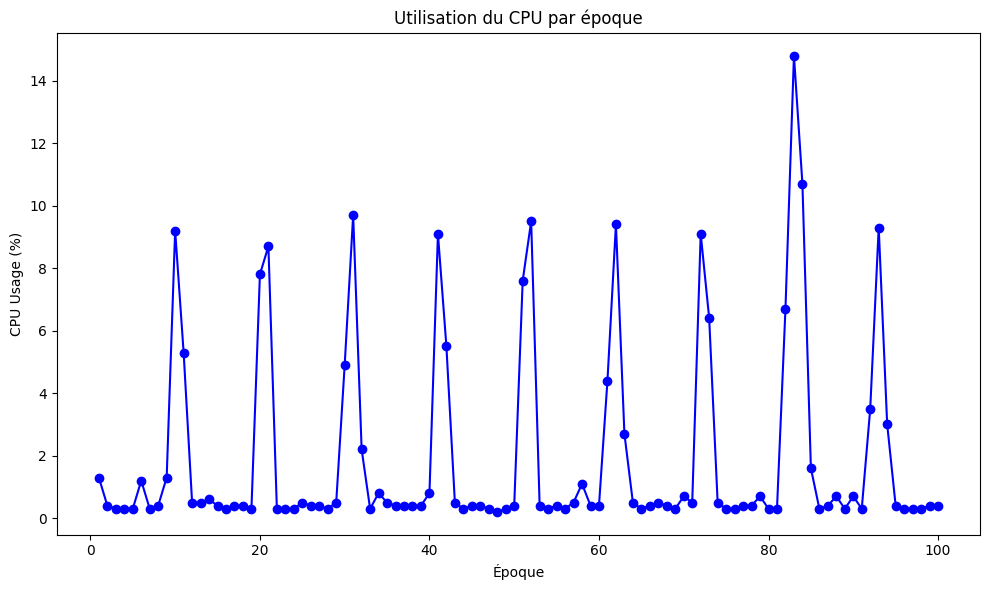

In [81]:
model_zc_b, history_zc_b = train_nn(X_train_tfidf_b.toarray(), train_labels_b, X_test_tfidf_b.toarray(), test_labels_b, epochs=100, batch_size=8)

### complexe

In [82]:
# Étape 1 : Préparation des données
vocab_size = 10000
embed_dim = 128
X_train_b_pad, X_test_b_pad, tokenizer, max_length = prepare_data(train_texts_b, test_texts_b, vocab_size=vocab_size)

#### RNN

Epoch 1/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.4290 - loss: 0.8536   Epoch 1 - CPU Usage: 0.3%
7/7 ━━━━━━━━━━━━━━━━━━━━ 21s 2s/step - accuracy: 0.4277 - loss: 0.8529 - val_accuracy: 0.5417 - val_loss: 0.6957
Epoch 2/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 190ms/step - accuracy: 0.5311 - loss: 0.7818Epoch 2 - CPU Usage: 0.3%
7/7 ━━━━━━━━━━━━━━━━━━━━ 2s 381ms/step - accuracy: 0.5264 - loss: 0.7859 - val_accuracy: 0.5833 - val_loss: 0.6731
Epoch 3/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 188ms/step - accuracy: 0.4808 - loss: 0.8098Epoch 3 - CPU Usage: 9.5%
7/7 ━━━━━━━━━━━━━━━━━━━━ 2s 379ms/step - accuracy: 0.4812 - loss: 0.8080 - val_accuracy: 0.5000 - val_loss: 0.6929
Epoch 4/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 188ms/step - accuracy: 0.5144 - loss: 0.7568Epoch 4 - CPU Usage: 0.5%
7/7 ━━━━━━━━━━━━━━━━━━━━ 2s 378ms/step - accuracy: 0.5153 - loss: 0.7573 - val_accuracy: 0.5833 - val_loss: 0.6890
Epoch 5/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 187ms/step - accuracy: 0.4643 - loss: 0.7641Epoch 5 - CPU Usag

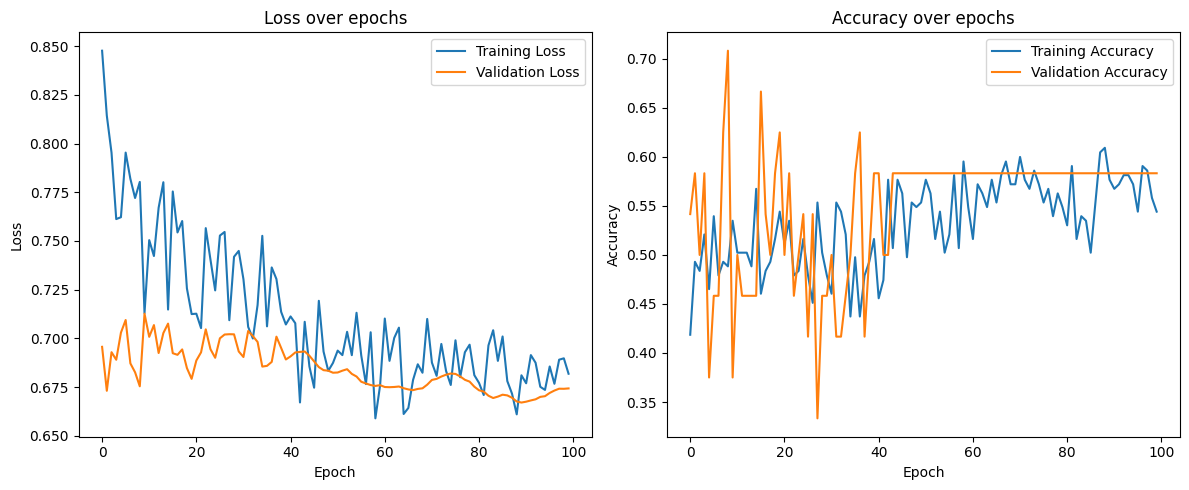

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/step


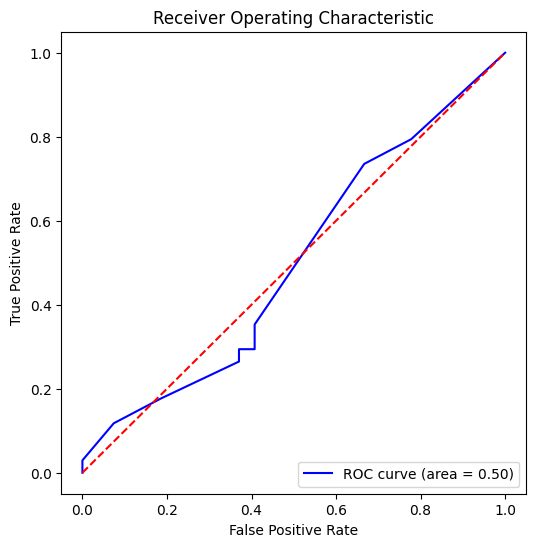

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step


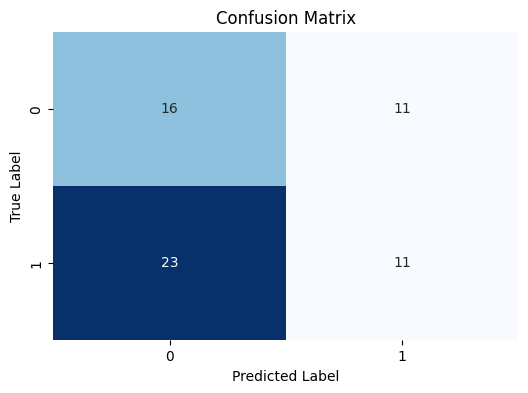

Ressource utilisation


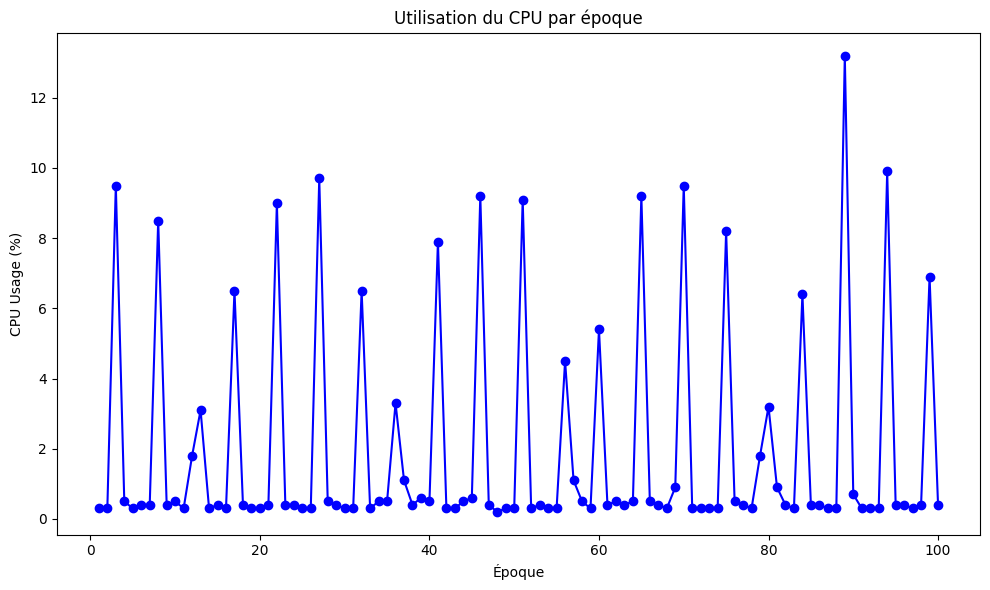

In [83]:
model_rnn_3_b = build_rnn_model_3(vocab_size, embed_dim, max_length)
history_rnn_3_b = train_model(model_rnn_3_b, X_train_b_pad, train_labels_b, X_test_b_pad, test_labels_b, epochs=100, batch_size=32)

#### LSTM

Epoch 1/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 223ms/step - accuracy: 0.5145 - loss: 0.6926Epoch 1 - CPU Usage: 0.4%
7/7 ━━━━━━━━━━━━━━━━━━━━ 10s 536ms/step - accuracy: 0.5112 - loss: 0.6935 - val_accuracy: 0.4583 - val_loss: 0.6958
Epoch 2/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 223ms/step - accuracy: 0.5753 - loss: 0.6923Epoch 2 - CPU Usage: 0.2%
7/7 ━━━━━━━━━━━━━━━━━━━━ 3s 418ms/step - accuracy: 0.5743 - loss: 0.6919 - val_accuracy: 0.4583 - val_loss: 0.6930
Epoch 3/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 225ms/step - accuracy: 0.5158 - loss: 0.6905Epoch 3 - CPU Usage: 9.8%
7/7 ━━━━━━━━━━━━━━━━━━━━ 3s 421ms/step - accuracy: 0.5118 - loss: 0.6909 - val_accuracy: 0.5417 - val_loss: 0.6903
Epoch 4/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 223ms/step - accuracy: 0.5225 - loss: 0.6892Epoch 4 - CPU Usage: 0.4%
7/7 ━━━━━━━━━━━━━━━━━━━━ 3s 418ms/step - accuracy: 0.5235 - loss: 0.6892 - val_accuracy: 0.5417 - val_loss: 0.6855
Epoch 5/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 224ms/step - accuracy: 0.5344 - loss: 0.6686Epoch 5 - CPU U

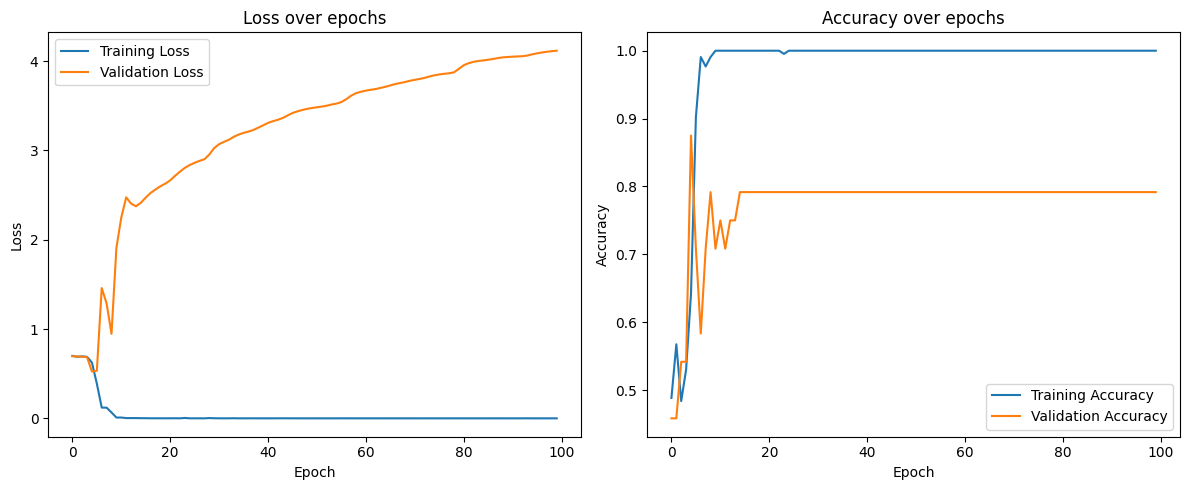

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step


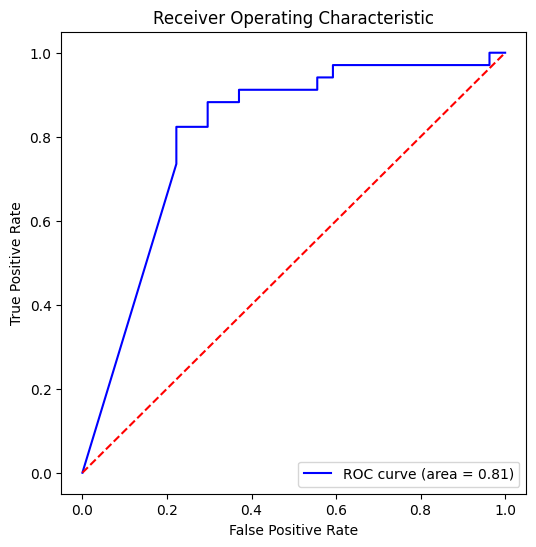

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step


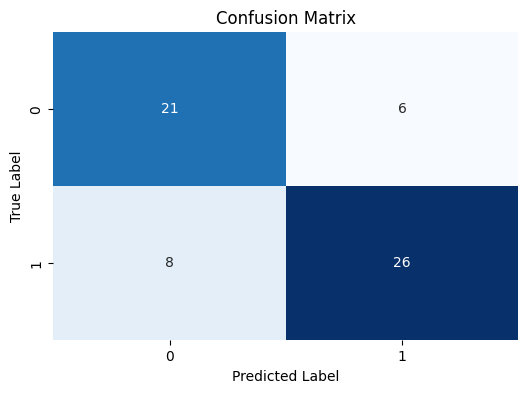

Ressource utilisation


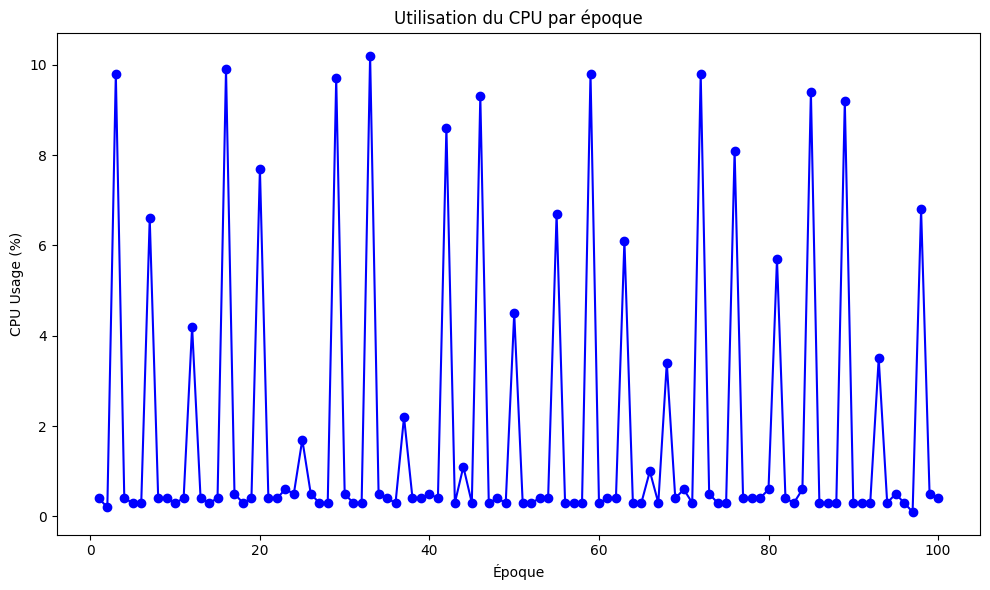

In [84]:
model_lstm_3_b = build_lstm_model_3(vocab_size, embed_dim, max_length)
history_lstm_3_b = train_model(model_lstm_3_b, X_train_b_pad, train_labels_b, X_test_b_pad, test_labels_b, epochs=100, batch_size=32)